In [3]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
mnist = input_data.read_data_sets("data/", one_hot=False)
print(mnist)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c374c68d0>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c374c6a20>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1c374c64e0>)


In [6]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
eps = 100

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 26 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [7]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [8]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [9]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3750e400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [10]:
# Define the input function for training
X_tr={'images': mnist.train.images}
Y_tr=mnist.train.labels
Y_tr = Y_tr - 1
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=X_tr, y=Y_tr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt.
INFO:tensorflow:loss = 3.2689598, step = 1
INFO:tensorflow:global_step/sec: 2.0828
INFO:tensorflow:loss = 0.99592006, step = 101 (48.013 sec)
INFO:tensorflow:global_step/sec: 2.06362
INFO:tensorflow:loss = 0.7668822, step = 201 (48.459 sec)
INFO:tensorflow:global_step/sec: 2.08496
INFO:tensorflow:loss = 0.681566, step = 301 (47.972 sec)
INFO:tensorflow:global_step/sec: 2.16846
INFO:tensorflow:loss = 0.67314154, step = 401 (46.106 sec)
INFO:tensorflow:Saving checkpoints for 500 into /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt.
INFO:tensorflow:Loss for final step: 0.7607191.


In [11]:
# Evaluate the Model
# Define the input function for evaluating
yt = mnist.test.labels
yt = yt - 1
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=yt,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-06-16:49:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-06-16:50:01
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.81711537, global_step = 500, loss = 0.61356497
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500


{'accuracy': 0.81711537, 'loss': 0.61356497, 'global_step': 500}

In [16]:
write = 1
if write==1:
    f = open("results/rotate.txt", 'w')

n_images = len(mnist.test.labels)
# Predict single images
# Get images from test set
test_images = mnist.test.images[:n_images]
test_label=mnist.test.labels[:n_images]
test_label = test_label - 1

# # reshape to be [samples][pixels][width][height]
X_test = test_images
y_test = test_label
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# # convert from int to float
X_test = X_test.astype('float32')

X_test_backup = X_test
Y_test_backup = y_test

yBackup = []
pBackup = []
accMat = []


In [17]:
angle = 0.0
for s in range(0,eps):
    X_test = X_test_backup
    y_test = Y_test_backup
    
    datagen = ImageDataGenerator(rotation_range=angle)# fit parameters from data
    datagen.fit(X_test)
    tmp = []
    # configure batch size and retrieve one batch of images
    for X_batch, y_batch in datagen.flow(X_test, y_test, batch_size=n_images, shuffle=False):
        tmp = X_batch
        yTemp = y_batch
        break
    y_test = yTemp
    X_test = tmp
    x_te={'images': tmp}
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x=x_te, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    accuracy = 0.0
    # Display
    for i in range(n_images):
        if (preds[i] == y_test[i]):
                accuracy = accuracy + 1/n_images
#         plt.imshow(np.reshape(tmp[i], [28, 28]), cmap='gray')
#         plt.show()
#         print("Model prediction:", preds[i])
    print("Model accuracy:", accuracy)
    yBackup.append(y_test)
    pBackup.append(preds)
    angle = angle+0.5
    accMat.append(accuracy)
    if write==1:
        f.write(str(angle)+"\t"+str(accuracy)+"\n")
if write==1:
    f.close()
print("Done!")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.8171153846155063
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.816298076923198
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op

INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7881730769231786
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7834615384616369
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.784471153846253
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
IN

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.7035096153846587
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.706538461538507
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.6986538461538861
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6j

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.5942788461538142
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.5869230769230399
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.5836057692307299
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.49538461538452067
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.4897115384614464
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmp4ck4g0yz/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.484086538461449
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/33/cbwqx9c11lgfbcvwxr2yf6

In [18]:
yTotal = [0]*num_classes

for y in y_test:
    yTotal[y] = yTotal[y]+1
print(yTotal)
aMatrix = []
for i in range(len(pBackup)):
    print("\n\nYmatrix for rotation %d"%(i))
    yMatrix = [[0]*num_classes for i in range(num_classes)]
    for j in range(len(pBackup[i])):
        yMatrix[yBackup[i][j]][pBackup[i][j]] += 1

    sum = 0
    
    for x in range(len(yMatrix)):
        for y in range(len(yMatrix[x])):
            yMatrix[x][y] = round(yMatrix[x][y]/yTotal[x], 3)

    aMatrix.append(yMatrix)
    for x in yMatrix:
        for y in x:
            print("%f" % (y),end=" ")
        print()
    

[800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800]


Ymatrix for rotation 0
0.660000 0.006000 0.043000 0.046000 0.007000 0.007000 0.024000 0.025000 0.001000 0.001000 0.003000 0.000000 0.007000 0.016000 0.024000 0.001000 0.077000 0.011000 0.001000 0.001000 0.011000 0.000000 0.007000 0.007000 0.000000 0.010000 
0.006000 0.915000 0.000000 0.003000 0.005000 0.000000 0.024000 0.010000 0.000000 0.000000 0.000000 0.005000 0.000000 0.003000 0.007000 0.000000 0.004000 0.001000 0.001000 0.001000 0.006000 0.000000 0.000000 0.004000 0.000000 0.005000 
0.004000 0.001000 0.926000 0.001000 0.018000 0.003000 0.003000 0.000000 0.004000 0.000000 0.000000 0.001000 0.000000 0.000000 0.009000 0.004000 0.010000 0.006000 0.000000 0.001000 0.009000 0.000000 0.001000 0.000000 0.000000 0.000000 
0.014000 0.061000 0.001000 0.755000 0.000000 0.000000 0.000000 0.003000 0.005000 0.009000 0.000000 0.026000 0.001000 0.005000 0.069000 0.00

0.003000 0.003000 0.005000 0.003000 0.016000 0.000000 0.005000 0.000000 0.014000 0.001000 0.000000 0.004000 0.000000 0.000000 0.000000 0.001000 0.004000 0.000000 0.000000 0.005000 0.000000 0.000000 0.000000 0.007000 0.000000 0.930000 


Ymatrix for rotation 3
0.664000 0.006000 0.040000 0.049000 0.011000 0.007000 0.021000 0.020000 0.001000 0.001000 0.003000 0.000000 0.007000 0.015000 0.025000 0.001000 0.075000 0.014000 0.001000 0.001000 0.010000 0.000000 0.009000 0.006000 0.000000 0.011000 
0.004000 0.924000 0.000000 0.004000 0.005000 0.000000 0.019000 0.010000 0.000000 0.000000 0.000000 0.006000 0.000000 0.003000 0.007000 0.000000 0.003000 0.001000 0.001000 0.001000 0.005000 0.000000 0.000000 0.003000 0.000000 0.005000 
0.004000 0.001000 0.925000 0.001000 0.019000 0.003000 0.001000 0.000000 0.004000 0.000000 0.000000 0.001000 0.000000 0.000000 0.009000 0.003000 0.009000 0.007000 0.001000 0.001000 0.009000 0.000000 0.001000 0.001000 0.000000 0.000000 
0.014000 0.068000 0.003000 0.752000

0.009000 0.003000 0.080000 0.001000 0.855000 0.016000 0.004000 0.000000 0.009000 0.001000 0.000000 0.000000 0.000000 0.000000 0.003000 0.001000 0.004000 0.007000 0.001000 0.003000 0.003000 0.000000 0.000000 0.000000 0.000000 0.001000 
0.001000 0.003000 0.001000 0.000000 0.013000 0.861000 0.011000 0.000000 0.010000 0.000000 0.000000 0.005000 0.000000 0.000000 0.000000 0.026000 0.009000 0.029000 0.004000 0.022000 0.000000 0.000000 0.000000 0.001000 0.004000 0.000000 
0.013000 0.065000 0.024000 0.001000 0.009000 0.006000 0.601000 0.000000 0.010000 0.009000 0.000000 0.001000 0.001000 0.001000 0.003000 0.000000 0.216000 0.001000 0.026000 0.001000 0.001000 0.000000 0.000000 0.004000 0.003000 0.004000 
0.007000 0.054000 0.000000 0.001000 0.000000 0.004000 0.004000 0.794000 0.006000 0.000000 0.020000 0.011000 0.024000 0.025000 0.000000 0.000000 0.000000 0.005000 0.000000 0.001000 0.015000 0.003000 0.013000 0.013000 0.001000 0.000000 
0.003000 0.005000 0.001000 0.001000 0.003000 0.005000 0.0050

0.001000 0.005000 0.001000 0.001000 0.001000 0.004000 0.005000 0.000000 0.881000 0.011000 0.000000 0.059000 0.000000 0.000000 0.000000 0.000000 0.001000 0.001000 0.001000 0.011000 0.003000 0.000000 0.000000 0.010000 0.000000 0.003000 
0.001000 0.025000 0.000000 0.016000 0.000000 0.005000 0.010000 0.000000 0.076000 0.785000 0.000000 0.010000 0.000000 0.000000 0.003000 0.000000 0.003000 0.000000 0.029000 0.019000 0.005000 0.001000 0.001000 0.006000 0.003000 0.003000 
0.003000 0.030000 0.003000 0.000000 0.003000 0.004000 0.001000 0.051000 0.003000 0.000000 0.810000 0.005000 0.005000 0.000000 0.000000 0.000000 0.000000 0.036000 0.000000 0.003000 0.006000 0.006000 0.001000 0.030000 0.001000 0.000000 
0.001000 0.015000 0.009000 0.001000 0.003000 0.013000 0.000000 0.001000 0.521000 0.001000 0.014000 0.370000 0.000000 0.001000 0.000000 0.000000 0.001000 0.003000 0.000000 0.015000 0.020000 0.000000 0.000000 0.006000 0.000000 0.005000 
0.003000 0.000000 0.000000 0.000000 0.000000 0.000000 0.0000

0.019000 0.000000 0.004000 0.010000 0.001000 0.000000 0.000000 0.024000 0.000000 0.001000 0.003000 0.000000 0.144000 0.662000 0.006000 0.001000 0.004000 0.020000 0.000000 0.003000 0.005000 0.003000 0.089000 0.001000 0.000000 0.001000 
0.000000 0.006000 0.005000 0.026000 0.004000 0.000000 0.004000 0.000000 0.003000 0.003000 0.000000 0.000000 0.000000 0.001000 0.922000 0.000000 0.004000 0.000000 0.000000 0.000000 0.019000 0.000000 0.004000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.000000 0.003000 0.001000 0.030000 0.003000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.004000 0.004000 0.877000 0.010000 0.054000 0.000000 0.005000 0.000000 0.004000 0.000000 0.001000 0.000000 0.000000 
0.031000 0.011000 0.006000 0.010000 0.010000 0.014000 0.106000 0.001000 0.018000 0.001000 0.000000 0.000000 0.001000 0.003000 0.015000 0.013000 0.733000 0.004000 0.001000 0.003000 0.007000 0.000000 0.004000 0.004000 0.001000 0.004000 
0.021000 0.007000 0.020000 0.000000 0.016000 0.019000 0.0010

0.025000 0.005000 0.013000 0.000000 0.018000 0.030000 0.001000 0.003000 0.013000 0.000000 0.009000 0.003000 0.006000 0.004000 0.000000 0.005000 0.007000 0.819000 0.001000 0.003000 0.000000 0.019000 0.006000 0.005000 0.003000 0.005000 
0.001000 0.009000 0.005000 0.000000 0.004000 0.000000 0.013000 0.000000 0.019000 0.014000 0.000000 0.000000 0.000000 0.001000 0.000000 0.000000 0.004000 0.004000 0.922000 0.000000 0.000000 0.000000 0.001000 0.003000 0.000000 0.001000 
0.000000 0.019000 0.005000 0.000000 0.011000 0.083000 0.004000 0.004000 0.039000 0.004000 0.001000 0.013000 0.001000 0.000000 0.001000 0.000000 0.005000 0.046000 0.000000 0.739000 0.000000 0.000000 0.000000 0.007000 0.009000 0.010000 
0.004000 0.000000 0.000000 0.011000 0.000000 0.001000 0.004000 0.015000 0.000000 0.001000 0.003000 0.001000 0.001000 0.001000 0.005000 0.000000 0.004000 0.003000 0.001000 0.000000 0.896000 0.021000 0.025000 0.001000 0.000000 0.001000 
0.000000 0.000000 0.000000 0.003000 0.001000 0.000000 0.0000

0.004000 0.004000 0.001000 0.000000 0.003000 0.004000 0.004000 0.000000 0.877000 0.007000 0.000000 0.064000 0.000000 0.000000 0.000000 0.001000 0.001000 0.001000 0.003000 0.009000 0.003000 0.000000 0.000000 0.010000 0.000000 0.005000 
0.001000 0.019000 0.001000 0.014000 0.000000 0.005000 0.011000 0.000000 0.074000 0.780000 0.000000 0.011000 0.000000 0.000000 0.003000 0.000000 0.004000 0.000000 0.035000 0.022000 0.004000 0.004000 0.003000 0.004000 0.004000 0.003000 
0.003000 0.025000 0.001000 0.000000 0.004000 0.007000 0.001000 0.048000 0.005000 0.000000 0.805000 0.006000 0.004000 0.000000 0.000000 0.001000 0.000000 0.035000 0.000000 0.003000 0.007000 0.006000 0.003000 0.035000 0.001000 0.000000 
0.001000 0.010000 0.009000 0.001000 0.001000 0.007000 0.000000 0.004000 0.507000 0.001000 0.013000 0.394000 0.000000 0.001000 0.000000 0.000000 0.001000 0.003000 0.000000 0.019000 0.019000 0.000000 0.000000 0.005000 0.000000 0.004000 
0.004000 0.000000 0.000000 0.000000 0.000000 0.000000 0.0010

0.001000 0.022000 0.005000 0.000000 0.011000 0.071000 0.003000 0.001000 0.049000 0.003000 0.000000 0.009000 0.003000 0.000000 0.004000 0.001000 0.007000 0.040000 0.000000 0.741000 0.000000 0.000000 0.000000 0.013000 0.013000 0.004000 
0.004000 0.001000 0.001000 0.011000 0.000000 0.000000 0.003000 0.013000 0.000000 0.003000 0.001000 0.003000 0.003000 0.004000 0.007000 0.000000 0.004000 0.003000 0.001000 0.000000 0.882000 0.026000 0.029000 0.001000 0.000000 0.001000 
0.000000 0.000000 0.000000 0.005000 0.001000 0.000000 0.000000 0.000000 0.004000 0.001000 0.001000 0.009000 0.001000 0.006000 0.000000 0.001000 0.001000 0.024000 0.000000 0.003000 0.087000 0.809000 0.031000 0.013000 0.003000 0.000000 
0.001000 0.003000 0.000000 0.011000 0.001000 0.001000 0.000000 0.006000 0.000000 0.001000 0.004000 0.000000 0.003000 0.011000 0.000000 0.000000 0.000000 0.000000 0.000000 0.001000 0.021000 0.003000 0.932000 0.000000 0.000000 0.000000 
0.007000 0.004000 0.001000 0.005000 0.000000 0.005000 0.0040

0.031000 0.015000 0.009000 0.011000 0.007000 0.026000 0.105000 0.001000 0.018000 0.000000 0.001000 0.000000 0.001000 0.003000 0.014000 0.011000 0.709000 0.003000 0.003000 0.007000 0.007000 0.000000 0.004000 0.003000 0.005000 0.006000 
0.021000 0.006000 0.022000 0.000000 0.015000 0.029000 0.001000 0.003000 0.009000 0.000000 0.013000 0.005000 0.009000 0.003000 0.000000 0.005000 0.013000 0.807000 0.001000 0.006000 0.000000 0.013000 0.004000 0.010000 0.001000 0.005000 
0.003000 0.010000 0.004000 0.000000 0.003000 0.004000 0.015000 0.000000 0.016000 0.022000 0.000000 0.000000 0.000000 0.001000 0.001000 0.000000 0.005000 0.007000 0.902000 0.000000 0.000000 0.000000 0.001000 0.004000 0.000000 0.001000 
0.000000 0.025000 0.004000 0.000000 0.009000 0.072000 0.003000 0.004000 0.037000 0.001000 0.009000 0.006000 0.001000 0.000000 0.003000 0.001000 0.009000 0.044000 0.000000 0.741000 0.000000 0.001000 0.000000 0.011000 0.011000 0.007000 
0.003000 0.000000 0.003000 0.013000 0.000000 0.001000 0.0070

0.000000 0.005000 0.003000 0.033000 0.003000 0.000000 0.005000 0.000000 0.000000 0.000000 0.000000 0.001000 0.000000 0.003000 0.912000 0.000000 0.011000 0.000000 0.000000 0.001000 0.020000 0.000000 0.004000 0.000000 0.000000 0.000000 
0.001000 0.000000 0.000000 0.004000 0.004000 0.055000 0.001000 0.000000 0.004000 0.000000 0.001000 0.001000 0.000000 0.003000 0.004000 0.819000 0.022000 0.070000 0.000000 0.006000 0.000000 0.004000 0.000000 0.001000 0.000000 0.000000 
0.033000 0.010000 0.006000 0.009000 0.011000 0.020000 0.107000 0.000000 0.018000 0.001000 0.001000 0.000000 0.001000 0.003000 0.011000 0.018000 0.713000 0.001000 0.006000 0.004000 0.011000 0.000000 0.005000 0.004000 0.003000 0.005000 
0.026000 0.005000 0.024000 0.000000 0.021000 0.029000 0.003000 0.003000 0.015000 0.000000 0.014000 0.004000 0.005000 0.006000 0.000000 0.005000 0.011000 0.789000 0.001000 0.005000 0.000000 0.015000 0.006000 0.005000 0.004000 0.005000 
0.001000 0.009000 0.003000 0.000000 0.005000 0.000000 0.0210

0.000000 0.018000 0.018000 0.000000 0.003000 0.010000 0.000000 0.001000 0.499000 0.001000 0.013000 0.389000 0.000000 0.000000 0.000000 0.000000 0.001000 0.007000 0.001000 0.009000 0.016000 0.000000 0.000000 0.009000 0.001000 0.005000 
0.004000 0.000000 0.000000 0.000000 0.000000 0.000000 0.006000 0.010000 0.000000 0.000000 0.001000 0.000000 0.929000 0.025000 0.000000 0.001000 0.004000 0.001000 0.000000 0.003000 0.001000 0.000000 0.013000 0.000000 0.000000 0.003000 
0.026000 0.000000 0.004000 0.010000 0.003000 0.000000 0.000000 0.026000 0.000000 0.000000 0.001000 0.000000 0.131000 0.624000 0.010000 0.003000 0.007000 0.016000 0.000000 0.004000 0.006000 0.004000 0.120000 0.003000 0.000000 0.003000 
0.000000 0.006000 0.005000 0.034000 0.003000 0.000000 0.004000 0.000000 0.001000 0.001000 0.000000 0.001000 0.000000 0.003000 0.915000 0.000000 0.007000 0.000000 0.000000 0.000000 0.016000 0.000000 0.004000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.001000 0.003000 0.004000 0.064000 0.0000

0.001000 0.003000 0.001000 0.001000 0.001000 0.009000 0.004000 0.003000 0.851000 0.009000 0.000000 0.062000 0.000000 0.000000 0.000000 0.000000 0.009000 0.003000 0.007000 0.019000 0.003000 0.000000 0.000000 0.009000 0.000000 0.006000 
0.003000 0.024000 0.000000 0.015000 0.000000 0.004000 0.009000 0.004000 0.061000 0.755000 0.000000 0.015000 0.000000 0.000000 0.006000 0.000000 0.010000 0.000000 0.052000 0.026000 0.004000 0.004000 0.001000 0.003000 0.003000 0.003000 
0.003000 0.025000 0.000000 0.000000 0.005000 0.011000 0.004000 0.061000 0.001000 0.000000 0.784000 0.007000 0.005000 0.000000 0.000000 0.000000 0.003000 0.033000 0.000000 0.011000 0.006000 0.007000 0.004000 0.029000 0.001000 0.000000 
0.001000 0.014000 0.020000 0.001000 0.003000 0.007000 0.000000 0.003000 0.505000 0.001000 0.013000 0.374000 0.000000 0.000000 0.000000 0.001000 0.001000 0.007000 0.000000 0.019000 0.018000 0.000000 0.000000 0.007000 0.000000 0.005000 
0.004000 0.000000 0.000000 0.000000 0.000000 0.000000 0.0050

0.020000 0.070000 0.028000 0.001000 0.006000 0.013000 0.570000 0.005000 0.005000 0.013000 0.000000 0.000000 0.004000 0.001000 0.004000 0.000000 0.204000 0.004000 0.037000 0.003000 0.004000 0.000000 0.000000 0.005000 0.003000 0.003000 
0.007000 0.081000 0.000000 0.000000 0.000000 0.000000 0.003000 0.743000 0.009000 0.000000 0.022000 0.013000 0.026000 0.015000 0.000000 0.001000 0.004000 0.007000 0.000000 0.003000 0.020000 0.003000 0.020000 0.022000 0.000000 0.001000 
0.001000 0.004000 0.001000 0.000000 0.001000 0.003000 0.007000 0.001000 0.835000 0.010000 0.000000 0.070000 0.000000 0.000000 0.000000 0.001000 0.010000 0.006000 0.004000 0.014000 0.003000 0.000000 0.000000 0.022000 0.000000 0.006000 
0.000000 0.024000 0.001000 0.015000 0.001000 0.005000 0.007000 0.000000 0.066000 0.744000 0.000000 0.013000 0.000000 0.000000 0.004000 0.000000 0.019000 0.001000 0.054000 0.026000 0.007000 0.003000 0.003000 0.003000 0.001000 0.004000 
0.003000 0.033000 0.003000 0.000000 0.004000 0.014000 0.0010

0.019000 0.099000 0.001000 0.625000 0.000000 0.001000 0.001000 0.004000 0.005000 0.020000 0.000000 0.030000 0.000000 0.020000 0.074000 0.001000 0.029000 0.009000 0.000000 0.007000 0.015000 0.004000 0.028000 0.005000 0.000000 0.004000 
0.010000 0.009000 0.102000 0.003000 0.811000 0.018000 0.007000 0.000000 0.005000 0.001000 0.000000 0.003000 0.000000 0.001000 0.001000 0.001000 0.004000 0.011000 0.003000 0.003000 0.001000 0.001000 0.000000 0.000000 0.000000 0.005000 
0.001000 0.005000 0.004000 0.001000 0.019000 0.812000 0.010000 0.001000 0.010000 0.000000 0.001000 0.006000 0.000000 0.001000 0.000000 0.035000 0.016000 0.033000 0.007000 0.025000 0.000000 0.000000 0.000000 0.006000 0.005000 0.000000 
0.020000 0.062000 0.026000 0.004000 0.005000 0.024000 0.537000 0.005000 0.013000 0.014000 0.000000 0.000000 0.001000 0.001000 0.006000 0.000000 0.214000 0.004000 0.050000 0.001000 0.003000 0.000000 0.001000 0.005000 0.003000 0.001000 
0.005000 0.081000 0.003000 0.003000 0.000000 0.003000 0.0030

0.588000 0.013000 0.036000 0.046000 0.016000 0.009000 0.036000 0.033000 0.000000 0.000000 0.003000 0.001000 0.014000 0.014000 0.041000 0.003000 0.085000 0.015000 0.001000 0.001000 0.016000 0.000000 0.010000 0.009000 0.000000 0.011000 
0.003000 0.882000 0.000000 0.005000 0.005000 0.004000 0.025000 0.016000 0.004000 0.000000 0.000000 0.005000 0.000000 0.005000 0.014000 0.000000 0.007000 0.007000 0.005000 0.003000 0.004000 0.000000 0.000000 0.001000 0.000000 0.005000 
0.003000 0.005000 0.894000 0.003000 0.019000 0.004000 0.006000 0.000000 0.003000 0.001000 0.000000 0.009000 0.000000 0.000000 0.014000 0.009000 0.006000 0.010000 0.001000 0.001000 0.010000 0.000000 0.003000 0.000000 0.000000 0.001000 
0.010000 0.090000 0.005000 0.629000 0.000000 0.003000 0.001000 0.009000 0.007000 0.029000 0.000000 0.030000 0.004000 0.011000 0.066000 0.003000 0.029000 0.005000 0.003000 0.004000 0.016000 0.003000 0.036000 0.009000 0.000000 0.000000 
0.007000 0.004000 0.100000 0.000000 0.815000 0.021000 0.0040

0.000000 0.007000 0.000000 0.001000 0.001000 0.009000 0.005000 0.003000 0.029000 0.011000 0.004000 0.022000 0.000000 0.001000 0.000000 0.003000 0.019000 0.004000 0.003000 0.066000 0.014000 0.077000 0.004000 0.060000 0.657000 0.000000 
0.005000 0.010000 0.021000 0.001000 0.026000 0.005000 0.007000 0.000000 0.019000 0.001000 0.000000 0.003000 0.000000 0.000000 0.000000 0.001000 0.013000 0.000000 0.000000 0.022000 0.000000 0.000000 0.001000 0.010000 0.000000 0.854000 


Ymatrix for rotation 40
0.571000 0.015000 0.041000 0.051000 0.020000 0.011000 0.030000 0.025000 0.001000 0.004000 0.004000 0.001000 0.016000 0.015000 0.034000 0.005000 0.085000 0.013000 0.004000 0.000000 0.018000 0.000000 0.024000 0.005000 0.000000 0.007000 
0.005000 0.889000 0.005000 0.004000 0.004000 0.004000 0.021000 0.016000 0.005000 0.000000 0.000000 0.006000 0.000000 0.004000 0.016000 0.000000 0.004000 0.003000 0.005000 0.000000 0.001000 0.000000 0.000000 0.000000 0.000000 0.009000 
0.003000 0.005000 0.902000 0.00100

0.000000 0.001000 0.003000 0.007000 0.006000 0.005000 0.001000 0.001000 0.005000 0.006000 0.005000 0.040000 0.001000 0.003000 0.001000 0.000000 0.004000 0.026000 0.000000 0.004000 0.125000 0.670000 0.062000 0.011000 0.010000 0.001000 
0.001000 0.004000 0.001000 0.016000 0.011000 0.001000 0.010000 0.011000 0.000000 0.001000 0.001000 0.000000 0.003000 0.010000 0.004000 0.000000 0.005000 0.001000 0.000000 0.000000 0.016000 0.007000 0.892000 0.001000 0.000000 0.001000 
0.013000 0.009000 0.001000 0.003000 0.001000 0.014000 0.003000 0.005000 0.005000 0.001000 0.040000 0.010000 0.003000 0.000000 0.001000 0.000000 0.001000 0.018000 0.000000 0.025000 0.003000 0.007000 0.003000 0.821000 0.013000 0.003000 
0.001000 0.007000 0.001000 0.001000 0.001000 0.010000 0.006000 0.006000 0.018000 0.010000 0.000000 0.014000 0.005000 0.000000 0.000000 0.000000 0.013000 0.005000 0.003000 0.069000 0.014000 0.075000 0.007000 0.058000 0.672000 0.004000 
0.006000 0.011000 0.016000 0.000000 0.036000 0.006000 0.0060

0.001000 0.014000 0.009000 0.000000 0.007000 0.087000 0.003000 0.006000 0.046000 0.006000 0.013000 0.011000 0.001000 0.001000 0.003000 0.003000 0.022000 0.049000 0.005000 0.639000 0.000000 0.001000 0.000000 0.030000 0.026000 0.016000 
0.006000 0.001000 0.009000 0.009000 0.003000 0.004000 0.029000 0.015000 0.001000 0.014000 0.004000 0.003000 0.007000 0.009000 0.011000 0.000000 0.016000 0.003000 0.001000 0.001000 0.781000 0.022000 0.048000 0.004000 0.000000 0.000000 
0.000000 0.000000 0.004000 0.011000 0.005000 0.019000 0.003000 0.001000 0.005000 0.003000 0.004000 0.049000 0.001000 0.007000 0.000000 0.000000 0.004000 0.022000 0.000000 0.010000 0.122000 0.631000 0.064000 0.014000 0.020000 0.001000 
0.004000 0.001000 0.003000 0.018000 0.024000 0.001000 0.005000 0.010000 0.000000 0.003000 0.003000 0.000000 0.004000 0.011000 0.000000 0.000000 0.003000 0.000000 0.000000 0.001000 0.024000 0.004000 0.882000 0.000000 0.000000 0.001000 
0.015000 0.009000 0.003000 0.001000 0.001000 0.013000 0.0040

0.035000 0.014000 0.011000 0.001000 0.019000 0.029000 0.100000 0.005000 0.015000 0.001000 0.000000 0.000000 0.001000 0.006000 0.014000 0.019000 0.680000 0.005000 0.001000 0.005000 0.011000 0.000000 0.007000 0.007000 0.004000 0.009000 
0.021000 0.007000 0.062000 0.000000 0.034000 0.052000 0.006000 0.005000 0.013000 0.000000 0.013000 0.005000 0.016000 0.004000 0.003000 0.014000 0.029000 0.662000 0.003000 0.015000 0.001000 0.011000 0.004000 0.009000 0.009000 0.003000 
0.009000 0.016000 0.005000 0.000000 0.005000 0.004000 0.051000 0.000000 0.013000 0.045000 0.001000 0.000000 0.000000 0.001000 0.007000 0.000000 0.009000 0.004000 0.819000 0.003000 0.001000 0.000000 0.003000 0.004000 0.000000 0.001000 
0.001000 0.021000 0.006000 0.001000 0.007000 0.094000 0.003000 0.003000 0.048000 0.004000 0.013000 0.009000 0.003000 0.000000 0.003000 0.005000 0.020000 0.050000 0.001000 0.621000 0.000000 0.003000 0.000000 0.041000 0.021000 0.024000 
0.011000 0.001000 0.007000 0.009000 0.006000 0.003000 0.0330

0.003000 0.016000 0.875000 0.003000 0.018000 0.004000 0.006000 0.001000 0.004000 0.003000 0.000000 0.010000 0.000000 0.000000 0.020000 0.003000 0.006000 0.011000 0.000000 0.001000 0.009000 0.000000 0.006000 0.000000 0.000000 0.003000 
0.015000 0.107000 0.005000 0.542000 0.003000 0.003000 0.004000 0.011000 0.007000 0.033000 0.000000 0.020000 0.003000 0.021000 0.084000 0.004000 0.036000 0.001000 0.000000 0.005000 0.016000 0.004000 0.064000 0.007000 0.000000 0.005000 
0.004000 0.016000 0.110000 0.001000 0.781000 0.015000 0.014000 0.000000 0.005000 0.003000 0.000000 0.004000 0.000000 0.000000 0.006000 0.001000 0.005000 0.011000 0.006000 0.004000 0.003000 0.000000 0.004000 0.001000 0.000000 0.006000 
0.001000 0.004000 0.005000 0.000000 0.037000 0.724000 0.026000 0.000000 0.014000 0.001000 0.010000 0.006000 0.004000 0.000000 0.000000 0.024000 0.021000 0.060000 0.011000 0.025000 0.000000 0.001000 0.001000 0.015000 0.009000 0.000000 
0.019000 0.087000 0.025000 0.004000 0.007000 0.028000 0.4990

0.003000 0.022000 0.004000 0.001000 0.004000 0.003000 0.054000 0.001000 0.033000 0.046000 0.003000 0.000000 0.000000 0.001000 0.015000 0.000000 0.006000 0.006000 0.786000 0.001000 0.003000 0.000000 0.004000 0.004000 0.000000 0.001000 
0.001000 0.021000 0.009000 0.001000 0.013000 0.074000 0.001000 0.003000 0.045000 0.007000 0.009000 0.006000 0.001000 0.000000 0.005000 0.003000 0.033000 0.049000 0.005000 0.624000 0.000000 0.004000 0.003000 0.050000 0.015000 0.020000 
0.004000 0.004000 0.011000 0.013000 0.006000 0.003000 0.039000 0.018000 0.001000 0.019000 0.001000 0.000000 0.004000 0.004000 0.018000 0.000000 0.026000 0.000000 0.001000 0.001000 0.745000 0.018000 0.064000 0.003000 0.000000 0.000000 
0.000000 0.001000 0.007000 0.010000 0.010000 0.018000 0.001000 0.000000 0.005000 0.011000 0.007000 0.052000 0.001000 0.004000 0.001000 0.000000 0.001000 0.024000 0.000000 0.009000 0.128000 0.606000 0.065000 0.019000 0.018000 0.001000 
0.009000 0.010000 0.000000 0.016000 0.033000 0.000000 0.0140

0.000000 0.003000 0.003000 0.000000 0.031000 0.710000 0.022000 0.000000 0.018000 0.000000 0.016000 0.011000 0.001000 0.000000 0.000000 0.040000 0.022000 0.050000 0.020000 0.022000 0.001000 0.000000 0.005000 0.016000 0.006000 0.001000 
0.021000 0.079000 0.034000 0.003000 0.007000 0.029000 0.496000 0.005000 0.005000 0.019000 0.000000 0.001000 0.006000 0.003000 0.010000 0.001000 0.189000 0.011000 0.059000 0.003000 0.005000 0.000000 0.004000 0.004000 0.004000 0.004000 
0.005000 0.115000 0.004000 0.001000 0.000000 0.003000 0.021000 0.671000 0.013000 0.001000 0.020000 0.010000 0.034000 0.011000 0.004000 0.001000 0.003000 0.007000 0.003000 0.006000 0.018000 0.003000 0.026000 0.020000 0.001000 0.000000 
0.001000 0.004000 0.003000 0.000000 0.003000 0.011000 0.005000 0.001000 0.797000 0.013000 0.001000 0.070000 0.000000 0.000000 0.000000 0.004000 0.018000 0.010000 0.011000 0.014000 0.004000 0.000000 0.000000 0.020000 0.000000 0.011000 
0.004000 0.030000 0.010000 0.013000 0.003000 0.009000 0.0280

0.010000 0.001000 0.010000 0.013000 0.011000 0.005000 0.056000 0.018000 0.000000 0.020000 0.004000 0.006000 0.007000 0.005000 0.015000 0.000000 0.031000 0.001000 0.000000 0.004000 0.691000 0.026000 0.058000 0.006000 0.000000 0.001000 
0.001000 0.000000 0.007000 0.011000 0.011000 0.016000 0.007000 0.001000 0.007000 0.014000 0.010000 0.068000 0.003000 0.010000 0.000000 0.000000 0.000000 0.018000 0.000000 0.010000 0.129000 0.557000 0.077000 0.018000 0.022000 0.001000 
0.007000 0.011000 0.001000 0.024000 0.040000 0.003000 0.019000 0.013000 0.000000 0.001000 0.003000 0.000000 0.001000 0.013000 0.001000 0.000000 0.013000 0.003000 0.000000 0.001000 0.033000 0.004000 0.806000 0.001000 0.001000 0.003000 
0.013000 0.011000 0.001000 0.003000 0.001000 0.030000 0.006000 0.005000 0.009000 0.003000 0.045000 0.015000 0.004000 0.000000 0.000000 0.000000 0.006000 0.021000 0.001000 0.087000 0.001000 0.013000 0.005000 0.705000 0.014000 0.001000 
0.000000 0.005000 0.001000 0.001000 0.000000 0.020000 0.0150

0.025000 0.009000 0.090000 0.000000 0.019000 0.059000 0.009000 0.005000 0.011000 0.000000 0.011000 0.003000 0.011000 0.009000 0.003000 0.007000 0.036000 0.636000 0.000000 0.024000 0.000000 0.007000 0.001000 0.004000 0.019000 0.003000 
0.005000 0.028000 0.003000 0.005000 0.010000 0.005000 0.069000 0.001000 0.014000 0.051000 0.001000 0.000000 0.000000 0.001000 0.018000 0.000000 0.010000 0.006000 0.760000 0.000000 0.005000 0.000000 0.004000 0.003000 0.000000 0.003000 
0.003000 0.025000 0.006000 0.000000 0.009000 0.081000 0.003000 0.003000 0.045000 0.009000 0.022000 0.010000 0.004000 0.001000 0.004000 0.003000 0.050000 0.049000 0.004000 0.534000 0.000000 0.000000 0.000000 0.077000 0.026000 0.034000 
0.004000 0.001000 0.019000 0.006000 0.010000 0.003000 0.056000 0.020000 0.000000 0.024000 0.003000 0.003000 0.006000 0.011000 0.020000 0.000000 0.029000 0.000000 0.001000 0.004000 0.703000 0.022000 0.054000 0.000000 0.000000 0.003000 
0.001000 0.003000 0.007000 0.004000 0.009000 0.013000 0.0070

0.001000 0.009000 0.020000 0.041000 0.000000 0.000000 0.011000 0.000000 0.000000 0.003000 0.000000 0.001000 0.001000 0.021000 0.858000 0.001000 0.011000 0.000000 0.000000 0.001000 0.016000 0.000000 0.004000 0.000000 0.000000 0.000000 
0.000000 0.000000 0.006000 0.003000 0.025000 0.109000 0.003000 0.000000 0.009000 0.000000 0.000000 0.004000 0.003000 0.004000 0.006000 0.656000 0.054000 0.091000 0.000000 0.015000 0.000000 0.004000 0.001000 0.003000 0.001000 0.005000 
0.046000 0.021000 0.019000 0.005000 0.016000 0.045000 0.111000 0.010000 0.018000 0.003000 0.001000 0.001000 0.001000 0.009000 0.016000 0.010000 0.609000 0.004000 0.004000 0.004000 0.018000 0.000000 0.006000 0.007000 0.005000 0.011000 
0.025000 0.016000 0.076000 0.000000 0.030000 0.062000 0.010000 0.006000 0.014000 0.000000 0.015000 0.004000 0.019000 0.007000 0.009000 0.021000 0.033000 0.599000 0.001000 0.025000 0.001000 0.005000 0.003000 0.003000 0.014000 0.003000 
0.009000 0.024000 0.006000 0.003000 0.005000 0.006000 0.0690

0.022000 0.003000 0.000000 0.000000 0.009000 0.001000 0.050000 0.007000 0.000000 0.001000 0.003000 0.000000 0.730000 0.028000 0.003000 0.001000 0.031000 0.054000 0.001000 0.020000 0.001000 0.000000 0.016000 0.001000 0.009000 0.009000 
0.028000 0.005000 0.015000 0.019000 0.007000 0.011000 0.039000 0.040000 0.000000 0.006000 0.003000 0.000000 0.115000 0.391000 0.044000 0.003000 0.052000 0.034000 0.001000 0.022000 0.015000 0.004000 0.139000 0.001000 0.003000 0.004000 
0.000000 0.015000 0.022000 0.036000 0.004000 0.000000 0.006000 0.000000 0.003000 0.001000 0.000000 0.000000 0.000000 0.020000 0.853000 0.003000 0.015000 0.003000 0.000000 0.001000 0.018000 0.000000 0.001000 0.000000 0.000000 0.000000 
0.003000 0.000000 0.005000 0.003000 0.039000 0.139000 0.001000 0.000000 0.011000 0.000000 0.000000 0.001000 0.003000 0.006000 0.001000 0.589000 0.072000 0.098000 0.000000 0.011000 0.000000 0.005000 0.001000 0.003000 0.005000 0.005000 
0.049000 0.024000 0.009000 0.011000 0.010000 0.041000 0.1210

0.003000 0.035000 0.021000 0.018000 0.009000 0.011000 0.040000 0.000000 0.068000 0.570000 0.000000 0.021000 0.000000 0.000000 0.009000 0.000000 0.031000 0.001000 0.090000 0.021000 0.005000 0.006000 0.026000 0.009000 0.004000 0.003000 
0.005000 0.028000 0.011000 0.000000 0.015000 0.045000 0.022000 0.061000 0.001000 0.001000 0.549000 0.026000 0.006000 0.000000 0.001000 0.000000 0.028000 0.059000 0.000000 0.041000 0.019000 0.005000 0.014000 0.060000 0.000000 0.003000 
0.001000 0.020000 0.071000 0.000000 0.010000 0.024000 0.000000 0.011000 0.414000 0.003000 0.009000 0.310000 0.000000 0.003000 0.000000 0.000000 0.000000 0.011000 0.006000 0.016000 0.007000 0.000000 0.001000 0.059000 0.000000 0.024000 
0.015000 0.003000 0.000000 0.000000 0.024000 0.004000 0.059000 0.015000 0.000000 0.001000 0.000000 0.000000 0.691000 0.024000 0.000000 0.003000 0.041000 0.071000 0.003000 0.014000 0.003000 0.001000 0.020000 0.000000 0.006000 0.004000 
0.033000 0.009000 0.022000 0.029000 0.006000 0.010000 0.0190

0.025000 0.094000 0.029000 0.001000 0.009000 0.030000 0.445000 0.013000 0.007000 0.018000 0.003000 0.001000 0.004000 0.001000 0.014000 0.004000 0.185000 0.003000 0.072000 0.005000 0.019000 0.003000 0.001000 0.007000 0.004000 0.005000 
0.011000 0.111000 0.005000 0.004000 0.000000 0.021000 0.054000 0.562000 0.004000 0.000000 0.020000 0.016000 0.049000 0.015000 0.006000 0.000000 0.011000 0.006000 0.006000 0.010000 0.025000 0.003000 0.030000 0.029000 0.000000 0.001000 
0.001000 0.001000 0.009000 0.000000 0.007000 0.014000 0.007000 0.003000 0.724000 0.011000 0.000000 0.077000 0.000000 0.000000 0.000000 0.001000 0.025000 0.007000 0.022000 0.025000 0.004000 0.001000 0.000000 0.036000 0.000000 0.022000 
0.004000 0.034000 0.013000 0.018000 0.009000 0.004000 0.024000 0.003000 0.043000 0.604000 0.000000 0.024000 0.000000 0.000000 0.006000 0.001000 0.045000 0.003000 0.096000 0.022000 0.015000 0.003000 0.018000 0.011000 0.004000 0.000000 
0.001000 0.036000 0.021000 0.000000 0.016000 0.049000 0.0350

0.006000 0.022000 0.010000 0.004000 0.011000 0.084000 0.005000 0.004000 0.037000 0.011000 0.018000 0.006000 0.004000 0.000000 0.005000 0.003000 0.056000 0.064000 0.007000 0.464000 0.000000 0.003000 0.003000 0.110000 0.025000 0.039000 
0.011000 0.003000 0.030000 0.010000 0.009000 0.007000 0.075000 0.020000 0.000000 0.040000 0.004000 0.005000 0.011000 0.009000 0.031000 0.000000 0.034000 0.003000 0.001000 0.003000 0.613000 0.015000 0.061000 0.001000 0.000000 0.005000 
0.001000 0.005000 0.009000 0.011000 0.010000 0.046000 0.007000 0.005000 0.006000 0.031000 0.010000 0.080000 0.001000 0.005000 0.004000 0.001000 0.001000 0.019000 0.000000 0.020000 0.128000 0.479000 0.074000 0.013000 0.034000 0.000000 
0.007000 0.020000 0.005000 0.034000 0.060000 0.003000 0.029000 0.020000 0.000000 0.013000 0.006000 0.000000 0.007000 0.009000 0.006000 0.000000 0.020000 0.001000 0.000000 0.003000 0.020000 0.005000 0.725000 0.003000 0.001000 0.004000 
0.014000 0.005000 0.000000 0.004000 0.003000 0.035000 0.0130

0.001000 0.004000 0.004000 0.000000 0.011000 0.009000 0.013000 0.000000 0.711000 0.018000 0.000000 0.074000 0.001000 0.000000 0.000000 0.005000 0.021000 0.021000 0.024000 0.016000 0.001000 0.000000 0.001000 0.039000 0.001000 0.025000 
0.003000 0.035000 0.030000 0.016000 0.006000 0.007000 0.029000 0.004000 0.049000 0.550000 0.000000 0.022000 0.000000 0.000000 0.009000 0.001000 0.055000 0.003000 0.095000 0.036000 0.009000 0.011000 0.019000 0.007000 0.001000 0.003000 
0.001000 0.033000 0.013000 0.000000 0.010000 0.065000 0.026000 0.061000 0.001000 0.001000 0.502000 0.030000 0.013000 0.000000 0.001000 0.000000 0.049000 0.046000 0.001000 0.049000 0.035000 0.004000 0.015000 0.041000 0.001000 0.001000 
0.000000 0.031000 0.077000 0.000000 0.010000 0.029000 0.000000 0.016000 0.403000 0.005000 0.009000 0.274000 0.000000 0.001000 0.000000 0.006000 0.000000 0.009000 0.006000 0.016000 0.014000 0.001000 0.003000 0.058000 0.000000 0.033000 
0.024000 0.003000 0.000000 0.000000 0.026000 0.005000 0.0610

0.001000 0.009000 0.009000 0.000000 0.043000 0.571000 0.048000 0.004000 0.011000 0.003000 0.013000 0.010000 0.010000 0.000000 0.000000 0.019000 0.049000 0.109000 0.021000 0.020000 0.003000 0.004000 0.004000 0.033000 0.007000 0.003000 
0.029000 0.096000 0.028000 0.000000 0.019000 0.026000 0.404000 0.020000 0.013000 0.021000 0.005000 0.003000 0.013000 0.003000 0.026000 0.004000 0.186000 0.003000 0.068000 0.003000 0.011000 0.001000 0.005000 0.004000 0.009000 0.004000 
0.009000 0.120000 0.006000 0.000000 0.003000 0.021000 0.048000 0.559000 0.013000 0.003000 0.014000 0.007000 0.046000 0.019000 0.005000 0.000000 0.015000 0.003000 0.010000 0.014000 0.021000 0.003000 0.031000 0.029000 0.001000 0.003000 
0.006000 0.004000 0.009000 0.000000 0.013000 0.015000 0.006000 0.005000 0.676000 0.014000 0.000000 0.075000 0.000000 0.000000 0.000000 0.004000 0.031000 0.020000 0.040000 0.019000 0.001000 0.000000 0.001000 0.043000 0.000000 0.019000 
0.009000 0.040000 0.018000 0.009000 0.014000 0.009000 0.0460

0.031000 0.160000 0.019000 0.346000 0.009000 0.013000 0.011000 0.015000 0.005000 0.050000 0.000000 0.020000 0.001000 0.013000 0.101000 0.004000 0.043000 0.001000 0.004000 0.015000 0.020000 0.005000 0.092000 0.013000 0.000000 0.010000 
0.010000 0.024000 0.141000 0.011000 0.659000 0.007000 0.033000 0.001000 0.006000 0.004000 0.001000 0.009000 0.001000 0.001000 0.020000 0.003000 0.014000 0.019000 0.010000 0.004000 0.000000 0.000000 0.016000 0.000000 0.001000 0.005000 
0.001000 0.007000 0.004000 0.000000 0.041000 0.555000 0.054000 0.003000 0.016000 0.001000 0.016000 0.011000 0.004000 0.001000 0.000000 0.026000 0.059000 0.085000 0.034000 0.024000 0.000000 0.004000 0.005000 0.037000 0.009000 0.003000 
0.039000 0.085000 0.029000 0.003000 0.006000 0.036000 0.403000 0.019000 0.006000 0.020000 0.006000 0.004000 0.014000 0.003000 0.024000 0.005000 0.185000 0.003000 0.070000 0.001000 0.013000 0.003000 0.009000 0.007000 0.006000 0.004000 
0.011000 0.126000 0.006000 0.005000 0.001000 0.019000 0.0600

0.354000 0.035000 0.035000 0.037000 0.039000 0.006000 0.056000 0.037000 0.003000 0.015000 0.003000 0.000000 0.030000 0.025000 0.056000 0.004000 0.166000 0.013000 0.011000 0.005000 0.014000 0.000000 0.033000 0.011000 0.001000 0.011000 
0.005000 0.684000 0.004000 0.009000 0.006000 0.004000 0.077000 0.045000 0.007000 0.014000 0.001000 0.004000 0.000000 0.005000 0.045000 0.000000 0.033000 0.001000 0.030000 0.005000 0.004000 0.001000 0.007000 0.003000 0.000000 0.006000 
0.001000 0.022000 0.801000 0.011000 0.030000 0.004000 0.014000 0.001000 0.005000 0.004000 0.000000 0.013000 0.000000 0.003000 0.025000 0.004000 0.004000 0.024000 0.000000 0.005000 0.024000 0.000000 0.005000 0.000000 0.000000 0.001000 
0.030000 0.165000 0.016000 0.324000 0.006000 0.006000 0.006000 0.025000 0.006000 0.036000 0.001000 0.019000 0.000000 0.031000 0.091000 0.003000 0.059000 0.004000 0.001000 0.014000 0.021000 0.006000 0.109000 0.011000 0.000000 0.009000 
0.009000 0.028000 0.139000 0.020000 0.645000 0.016000 0.0200

0.011000 0.013000 0.003000 0.000000 0.004000 0.066000 0.018000 0.015000 0.004000 0.003000 0.046000 0.011000 0.005000 0.003000 0.001000 0.000000 0.005000 0.010000 0.000000 0.251000 0.003000 0.004000 0.004000 0.520000 0.003000 0.000000 
0.006000 0.013000 0.005000 0.000000 0.001000 0.065000 0.010000 0.005000 0.020000 0.014000 0.004000 0.039000 0.006000 0.000000 0.005000 0.000000 0.014000 0.005000 0.009000 0.163000 0.014000 0.043000 0.020000 0.079000 0.459000 0.004000 
0.007000 0.013000 0.062000 0.005000 0.114000 0.026000 0.016000 0.001000 0.006000 0.006000 0.000000 0.000000 0.005000 0.007000 0.003000 0.003000 0.092000 0.003000 0.009000 0.060000 0.003000 0.001000 0.010000 0.009000 0.000000 0.539000 


Ymatrix for rotation 90
0.328000 0.035000 0.034000 0.029000 0.030000 0.016000 0.052000 0.033000 0.000000 0.016000 0.004000 0.003000 0.030000 0.018000 0.049000 0.010000 0.186000 0.020000 0.011000 0.010000 0.018000 0.000000 0.045000 0.010000 0.000000 0.015000 
0.014000 0.686000 0.006000 0.00500

0.003000 0.009000 0.007000 0.016000 0.025000 0.090000 0.013000 0.006000 0.006000 0.046000 0.010000 0.117000 0.003000 0.004000 0.007000 0.000000 0.001000 0.015000 0.003000 0.019000 0.111000 0.365000 0.075000 0.013000 0.034000 0.003000 
0.021000 0.015000 0.005000 0.037000 0.101000 0.001000 0.028000 0.021000 0.003000 0.014000 0.006000 0.003000 0.003000 0.009000 0.009000 0.000000 0.036000 0.006000 0.001000 0.001000 0.025000 0.004000 0.629000 0.007000 0.006000 0.009000 
0.011000 0.010000 0.004000 0.003000 0.003000 0.061000 0.011000 0.020000 0.004000 0.001000 0.044000 0.026000 0.006000 0.000000 0.000000 0.000000 0.009000 0.014000 0.000000 0.240000 0.004000 0.003000 0.007000 0.510000 0.009000 0.001000 
0.003000 0.006000 0.001000 0.003000 0.001000 0.094000 0.013000 0.004000 0.014000 0.011000 0.003000 0.030000 0.004000 0.000000 0.001000 0.001000 0.009000 0.001000 0.006000 0.196000 0.011000 0.030000 0.022000 0.090000 0.439000 0.007000 
0.013000 0.014000 0.080000 0.005000 0.102000 0.020000 0.0090

0.015000 0.058000 0.025000 0.005000 0.013000 0.003000 0.126000 0.003000 0.014000 0.071000 0.001000 0.004000 0.000000 0.001000 0.037000 0.000000 0.018000 0.011000 0.552000 0.004000 0.015000 0.003000 0.015000 0.004000 0.003000 0.001000 
0.003000 0.028000 0.009000 0.003000 0.014000 0.068000 0.005000 0.005000 0.020000 0.016000 0.025000 0.009000 0.005000 0.003000 0.003000 0.022000 0.052000 0.054000 0.009000 0.453000 0.000000 0.001000 0.000000 0.122000 0.030000 0.044000 
0.021000 0.005000 0.055000 0.014000 0.015000 0.019000 0.105000 0.018000 0.000000 0.070000 0.007000 0.003000 0.016000 0.016000 0.039000 0.000000 0.029000 0.001000 0.004000 0.009000 0.480000 0.016000 0.054000 0.001000 0.001000 0.003000 
0.004000 0.010000 0.009000 0.021000 0.021000 0.099000 0.014000 0.006000 0.004000 0.050000 0.010000 0.113000 0.003000 0.003000 0.001000 0.001000 0.003000 0.016000 0.000000 0.022000 0.120000 0.351000 0.076000 0.022000 0.020000 0.001000 
0.019000 0.015000 0.006000 0.049000 0.111000 0.003000 0.0400

0.035000 0.026000 0.018000 0.011000 0.028000 0.060000 0.128000 0.009000 0.016000 0.005000 0.000000 0.000000 0.009000 0.004000 0.022000 0.015000 0.516000 0.013000 0.007000 0.006000 0.018000 0.001000 0.016000 0.018000 0.004000 0.016000 
0.021000 0.018000 0.129000 0.000000 0.028000 0.060000 0.020000 0.009000 0.010000 0.000000 0.010000 0.011000 0.018000 0.006000 0.011000 0.011000 0.052000 0.472000 0.006000 0.051000 0.004000 0.007000 0.003000 0.007000 0.031000 0.004000 
0.010000 0.052000 0.025000 0.010000 0.007000 0.003000 0.129000 0.006000 0.022000 0.059000 0.000000 0.006000 0.001000 0.003000 0.036000 0.000000 0.011000 0.020000 0.544000 0.003000 0.028000 0.006000 0.014000 0.000000 0.005000 0.000000 
0.004000 0.024000 0.013000 0.003000 0.011000 0.080000 0.004000 0.005000 0.043000 0.007000 0.026000 0.011000 0.005000 0.000000 0.006000 0.015000 0.075000 0.037000 0.013000 0.409000 0.000000 0.001000 0.001000 0.140000 0.029000 0.039000 
0.018000 0.007000 0.059000 0.018000 0.011000 0.013000 0.0950

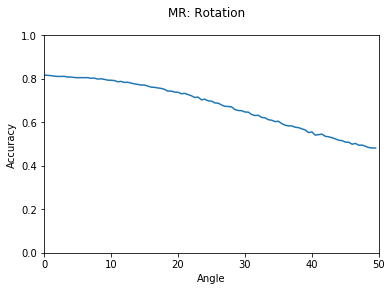

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.axis([0, 50, 0, 1])
plt.plot(np.arange(0,50,0.5),accMat)
plt.xlabel("Angle")
plt.ylabel("Accuracy")
plt.suptitle("MR: Rotation")
plt.show()

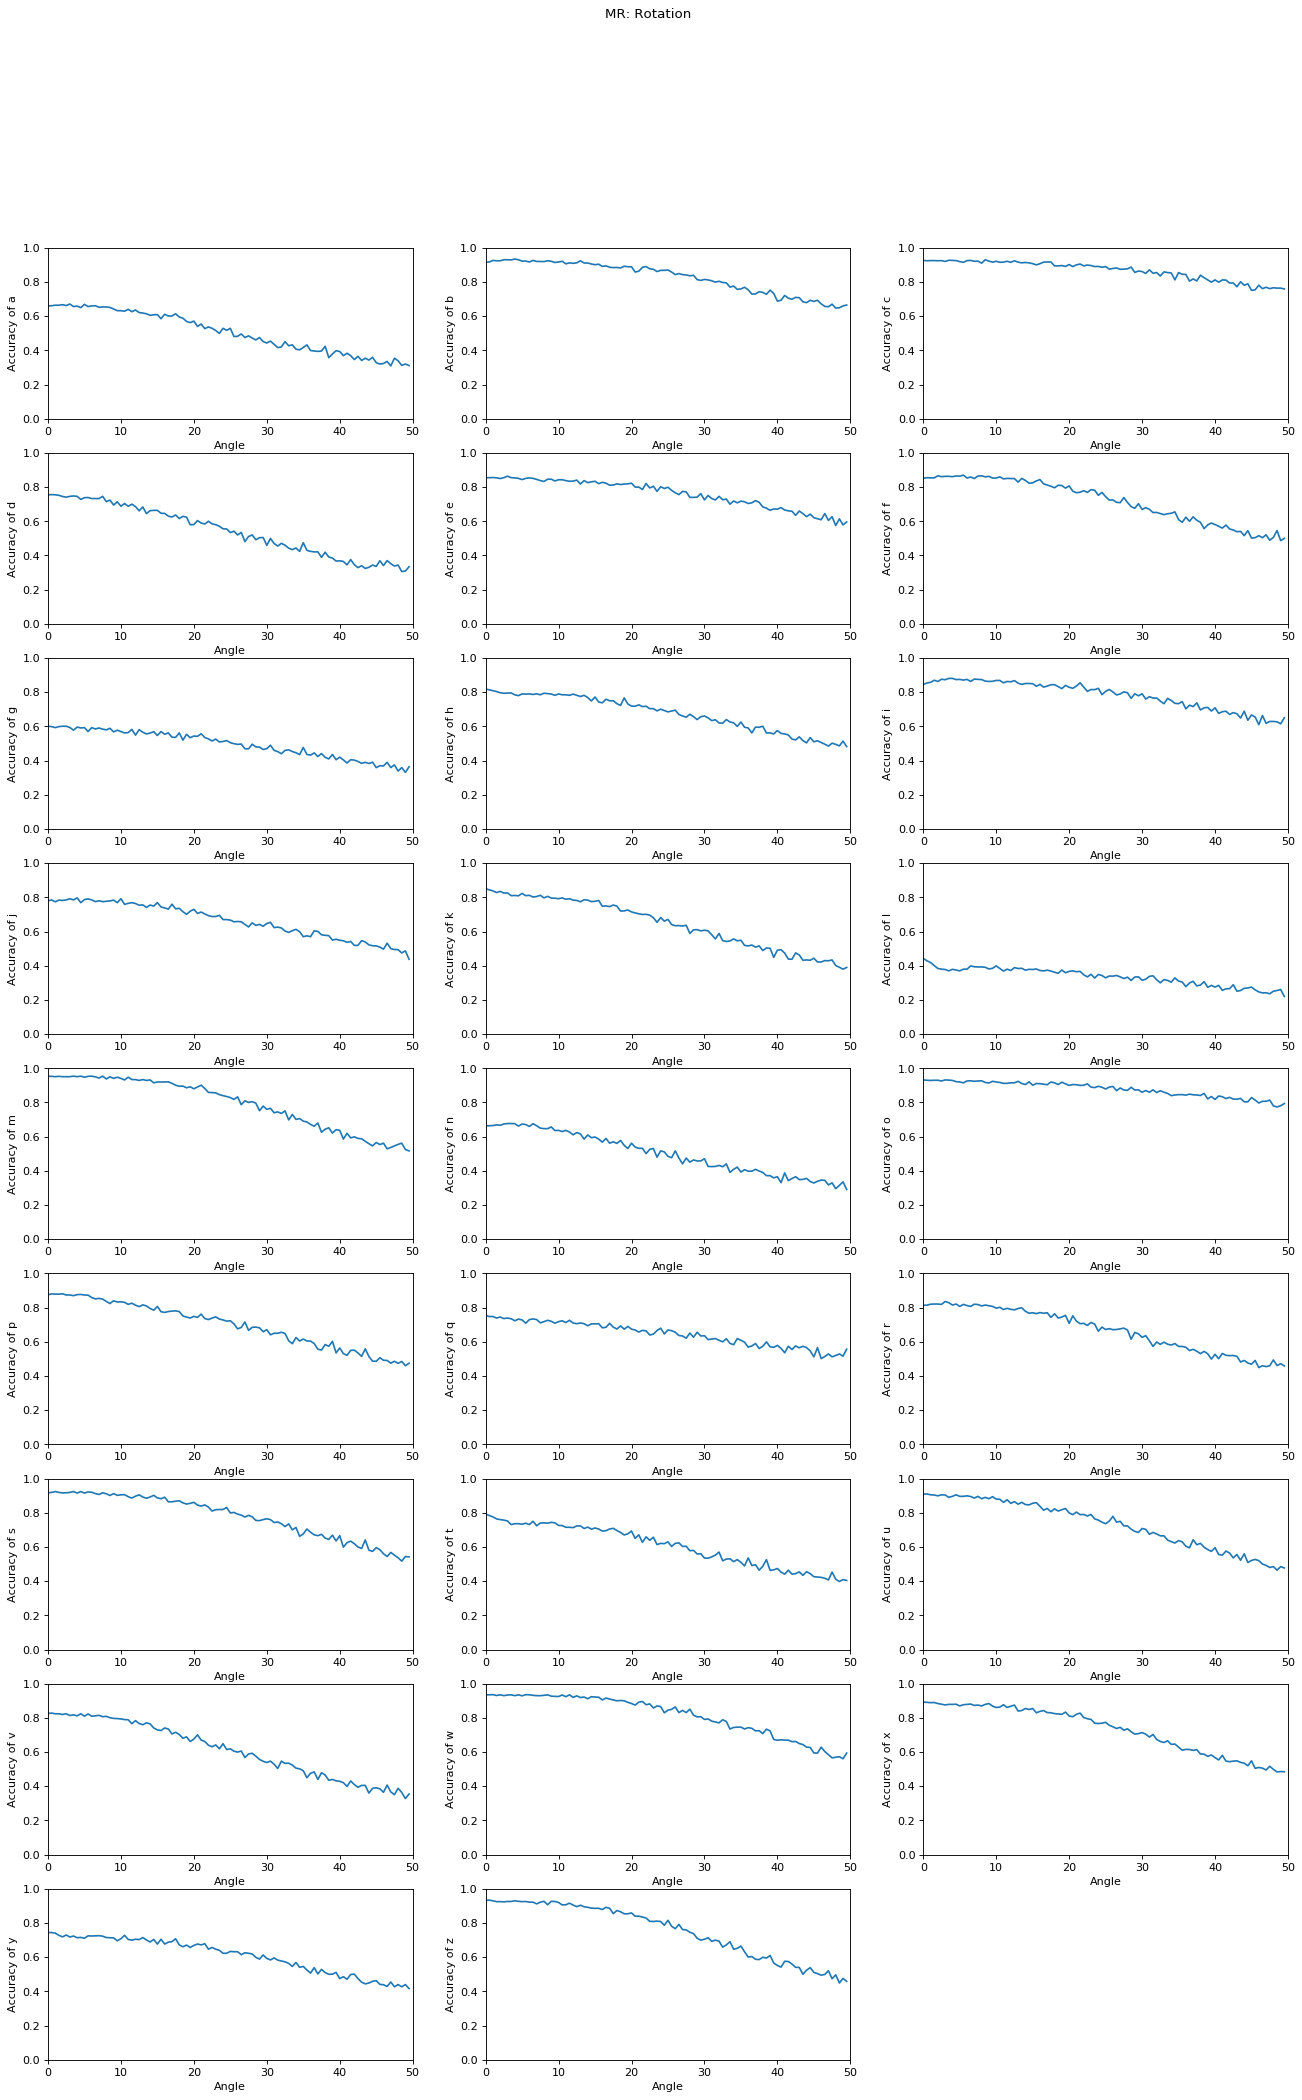

In [28]:
figure(num=None, figsize=(20, 30), dpi=80, facecolor='w', edgecolor='k')

zero = []
for j in range(num_classes):
    zero = []
    for i in range(len(aMatrix)):
        zero.append(aMatrix[i][j][j])
    plt.subplot(9,3,j+1)
    plt.axis([0, 50, 0, 1])
    plt.plot(np.arange(0,50,0.5),zero)
    plt.xlabel("Angle")
    plt.ylabel("Accuracy of %s" %chr(97+j))
plt.suptitle("MR: Rotation")
plt.show()

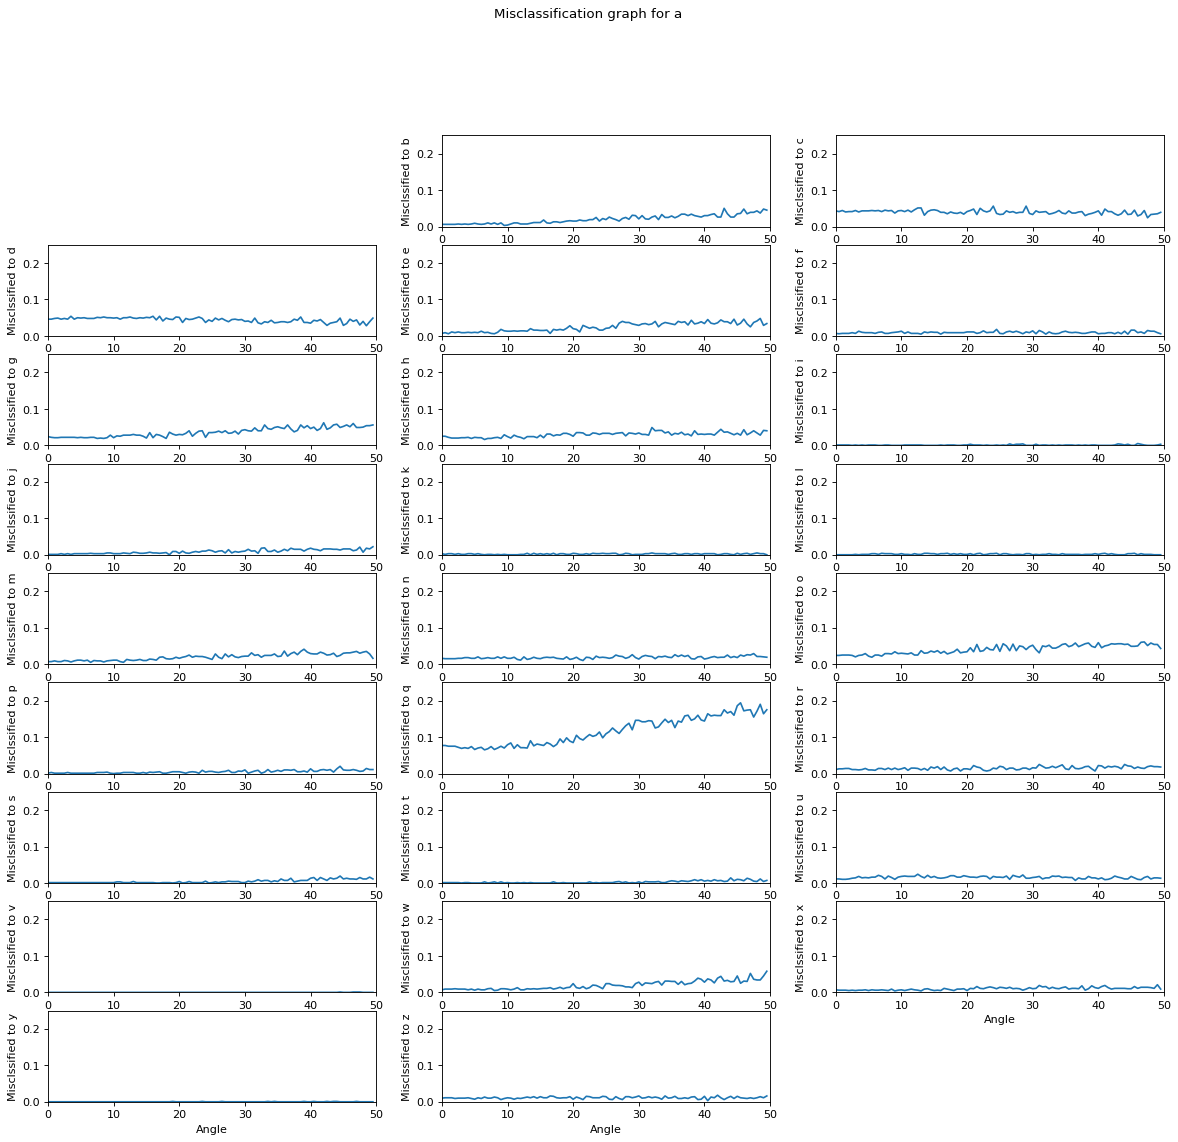

---------------------------------------------------------------------------------------------------------------------


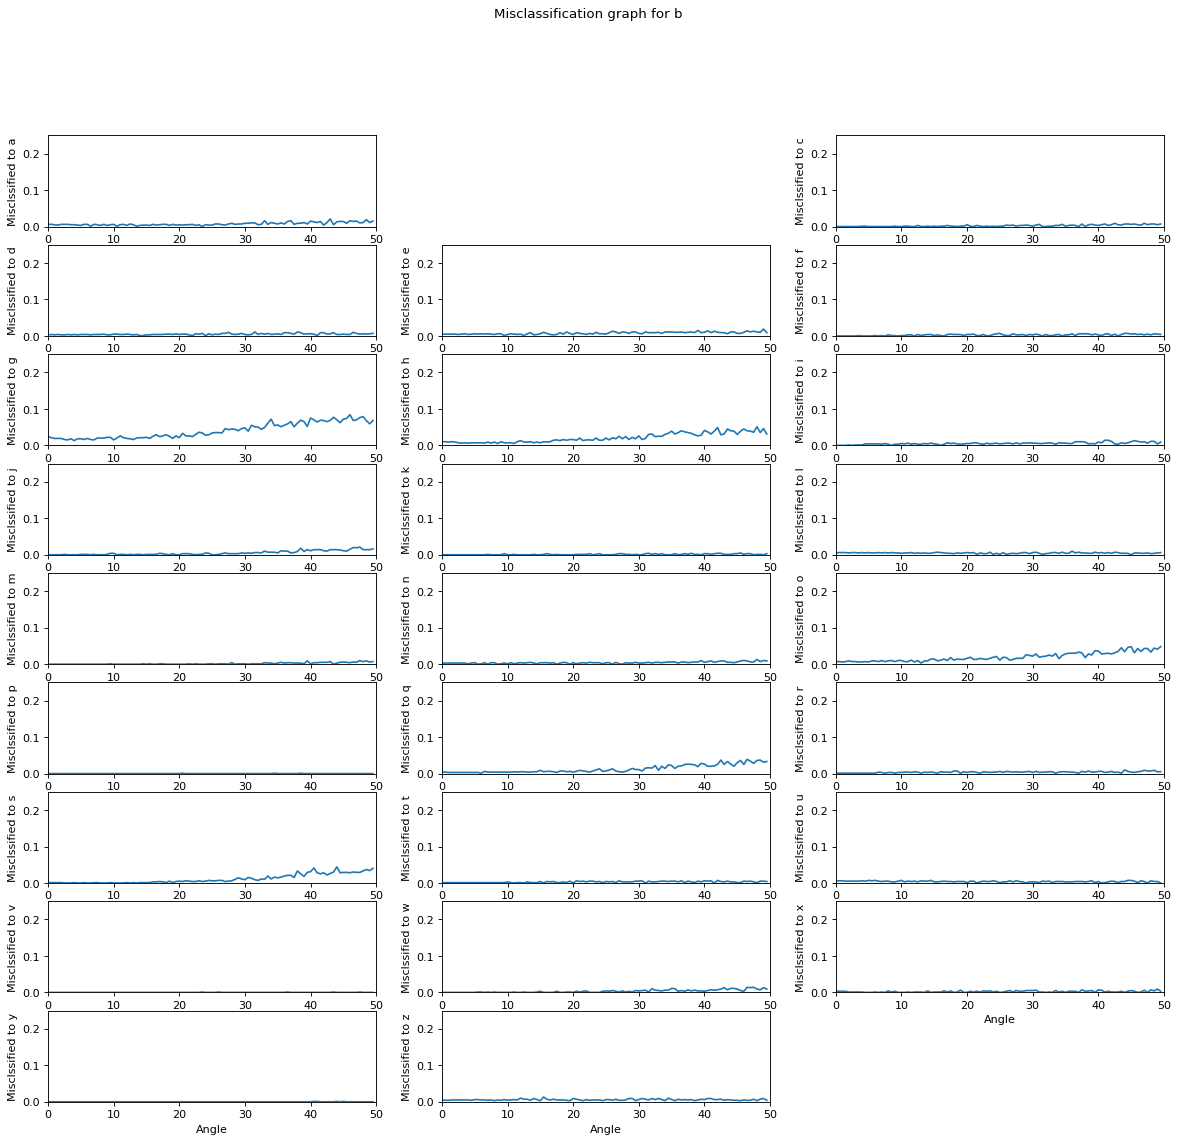

---------------------------------------------------------------------------------------------------------------------


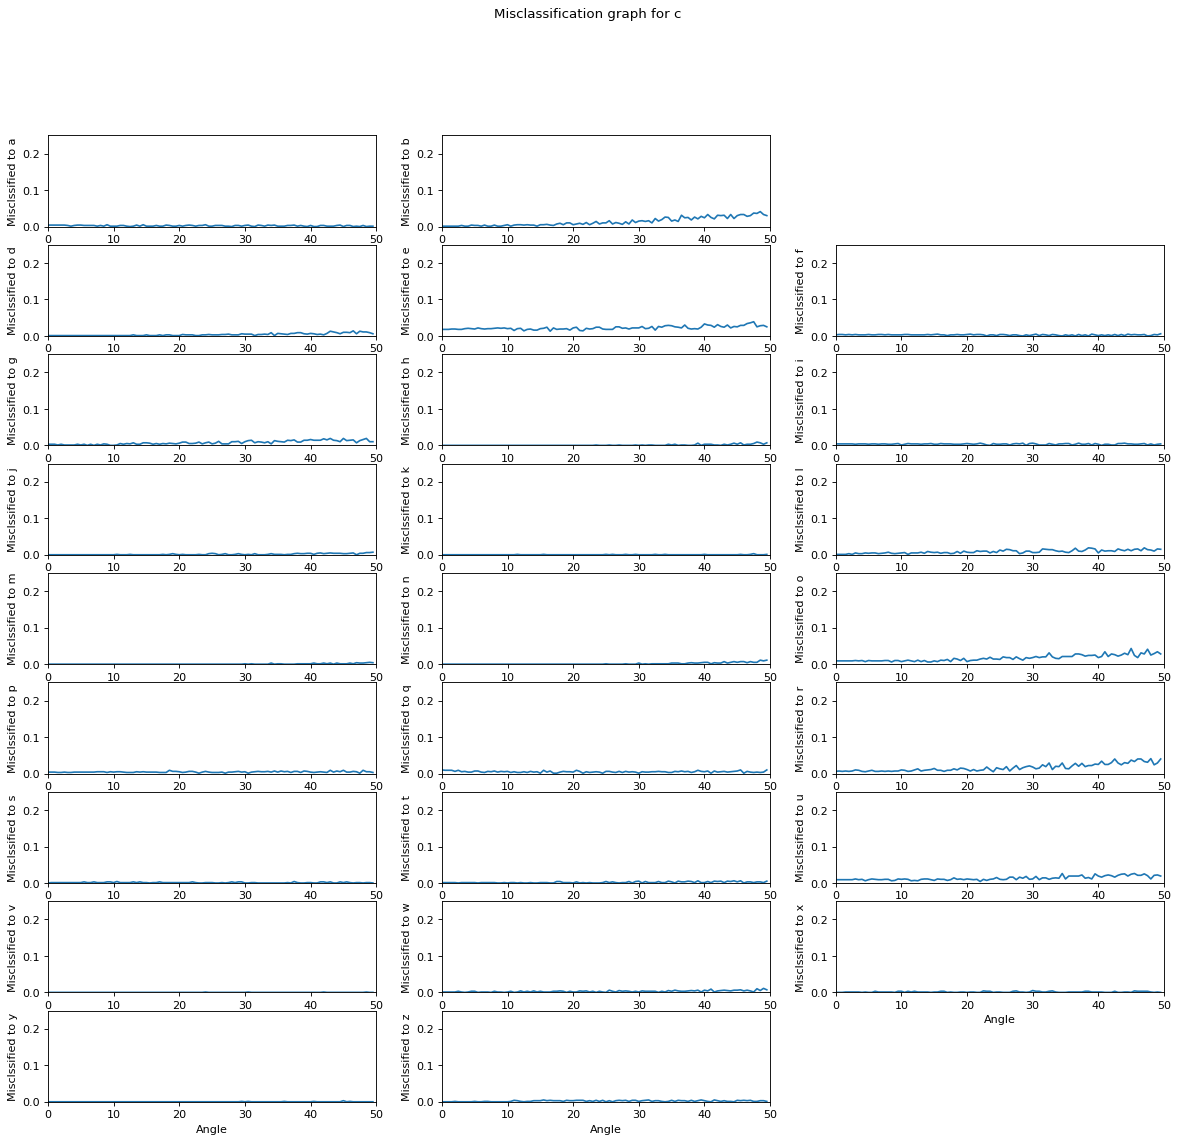

---------------------------------------------------------------------------------------------------------------------


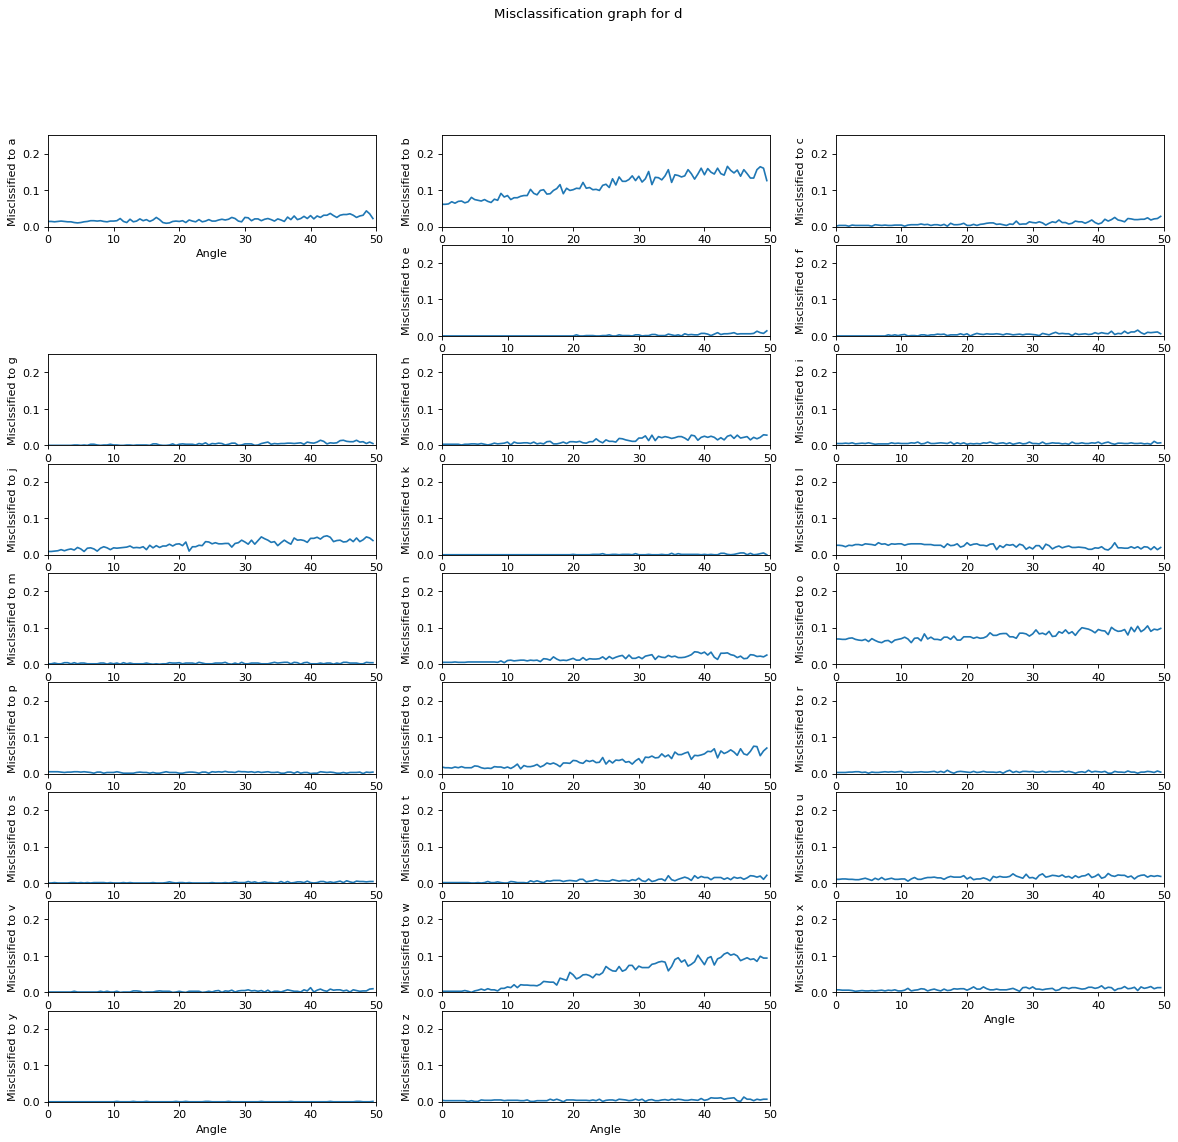

---------------------------------------------------------------------------------------------------------------------


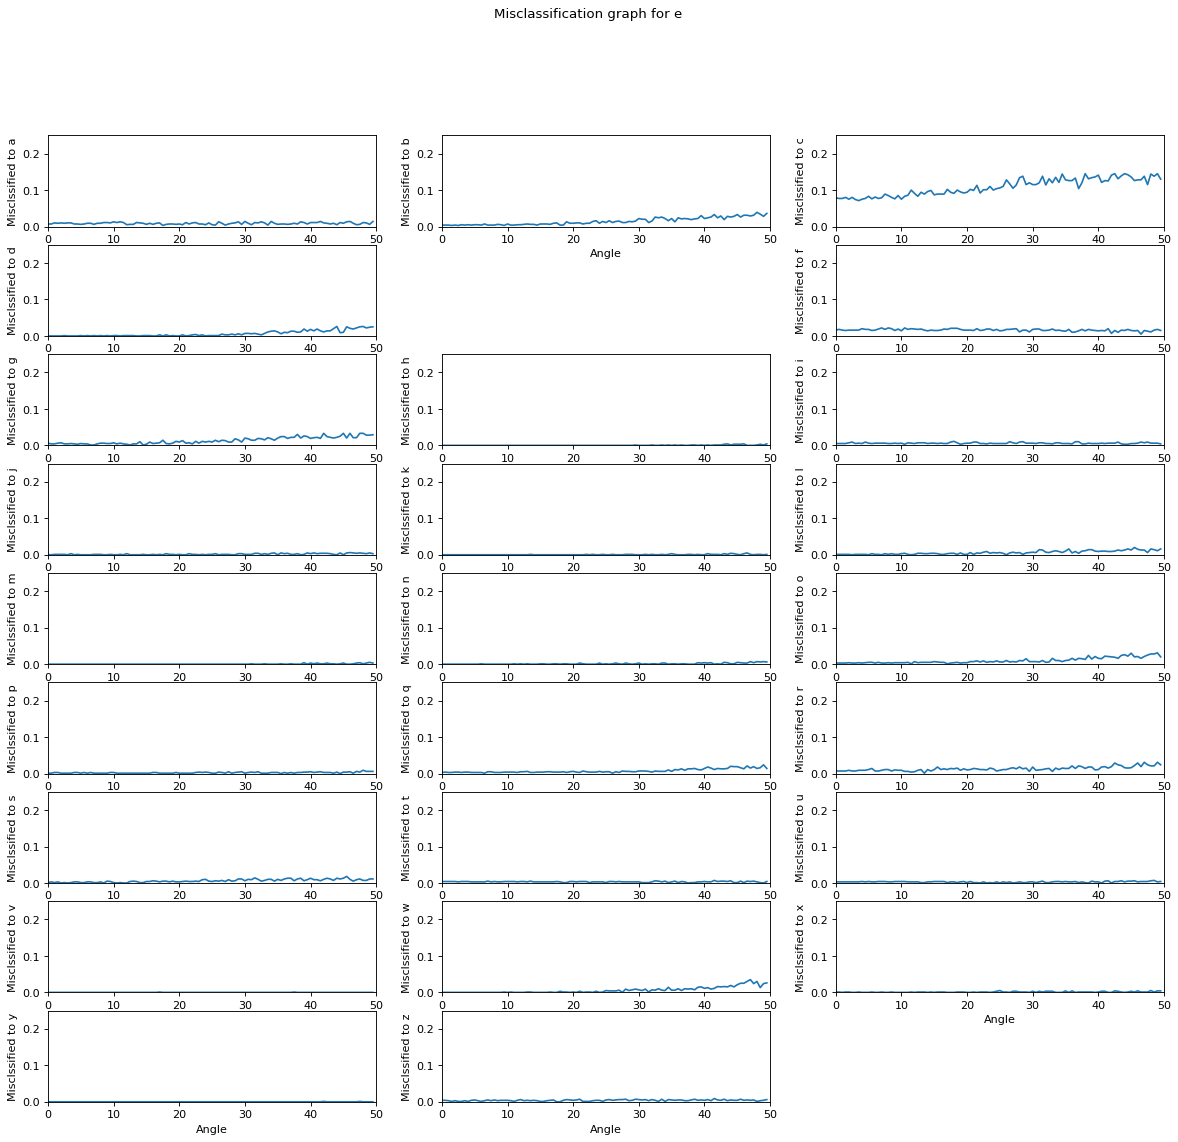

---------------------------------------------------------------------------------------------------------------------


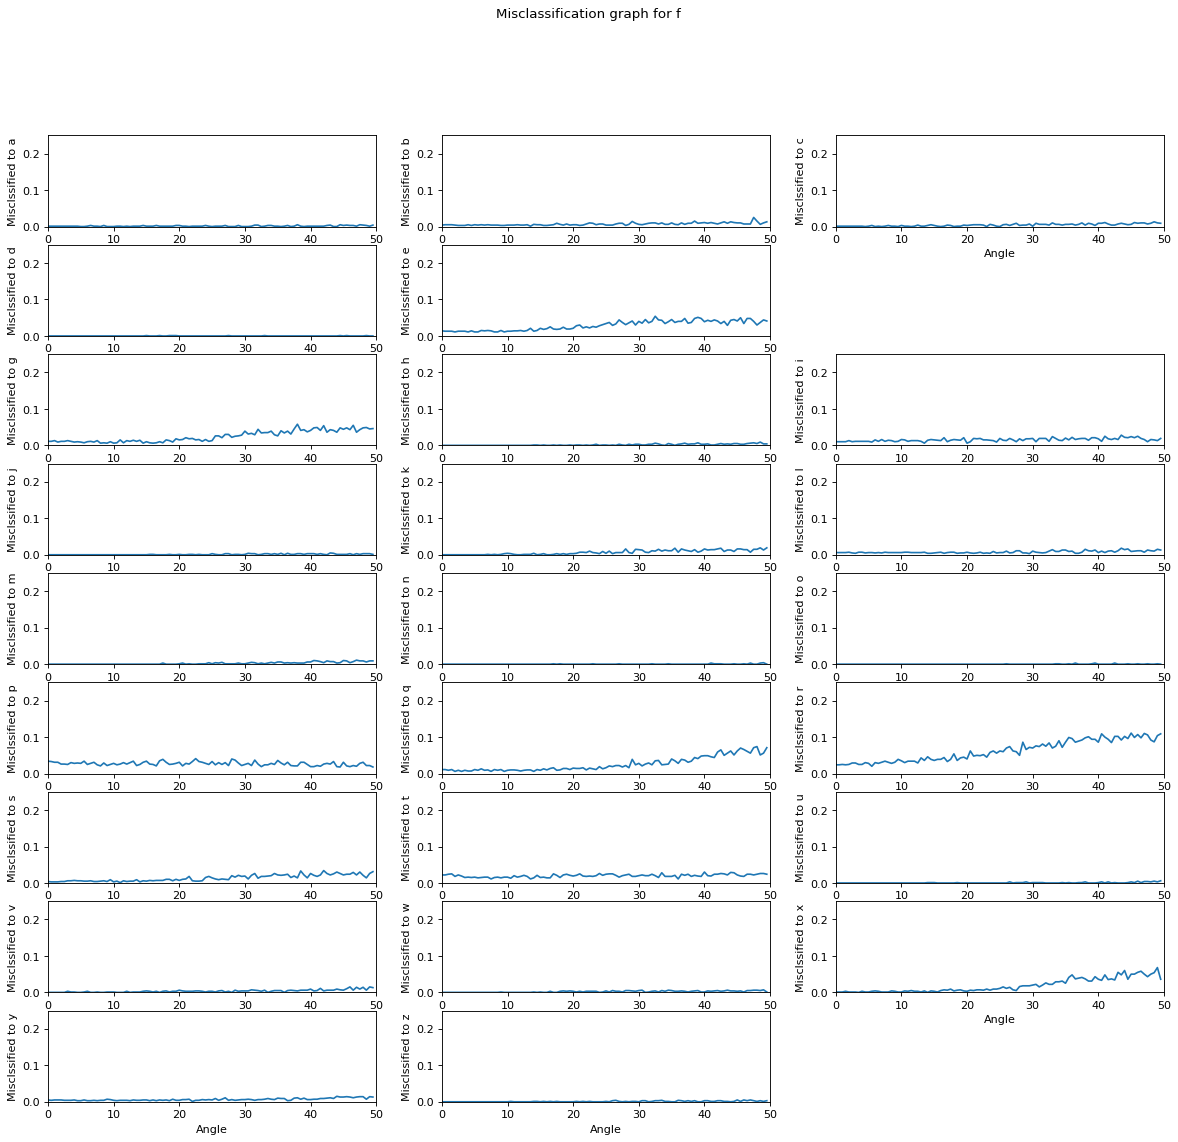

---------------------------------------------------------------------------------------------------------------------


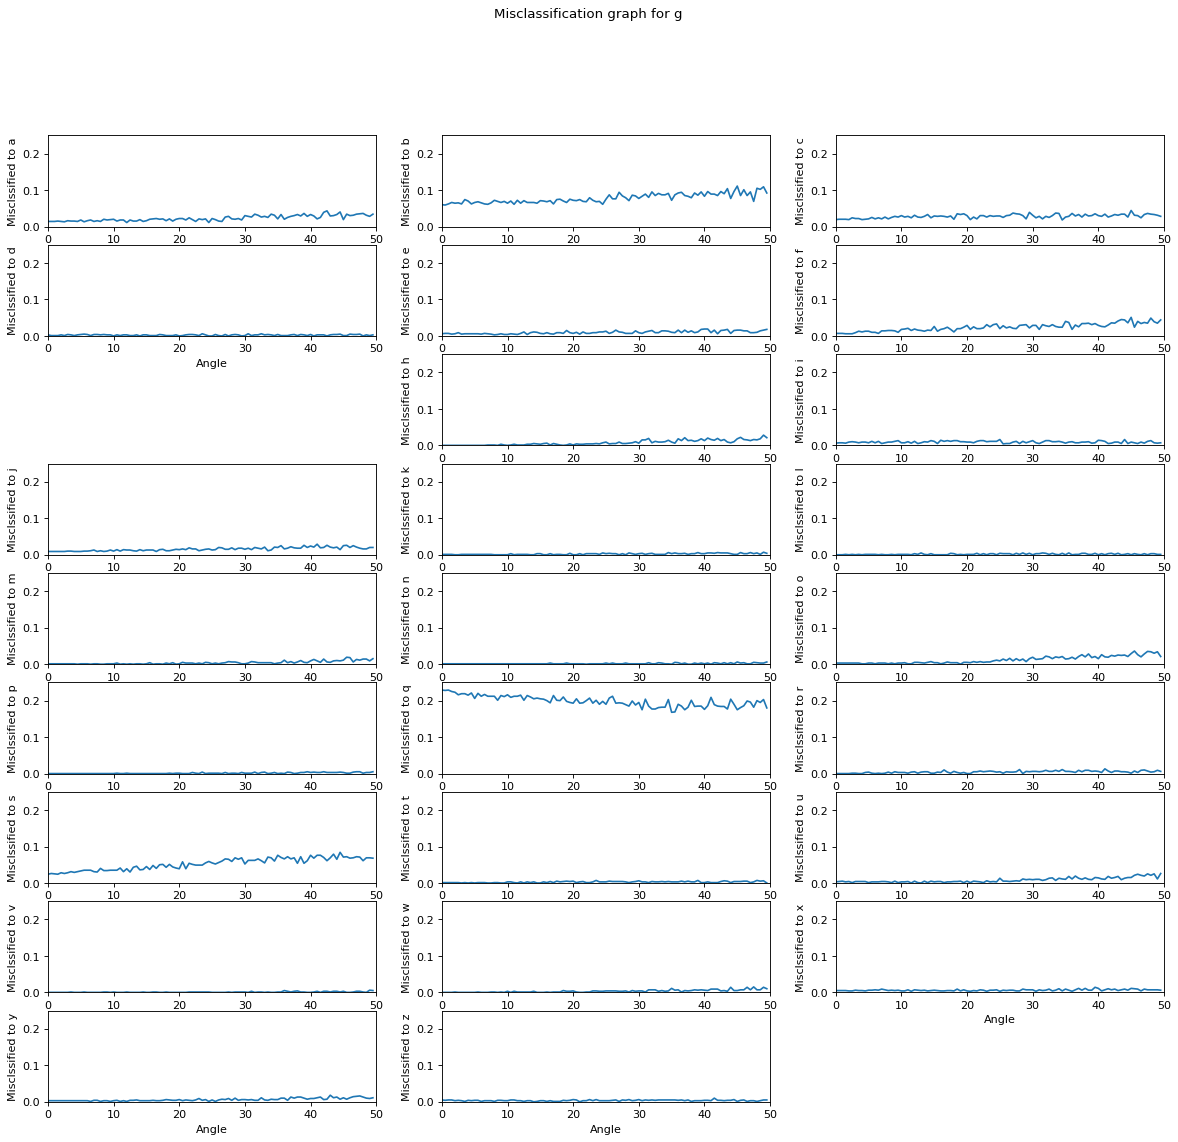

---------------------------------------------------------------------------------------------------------------------


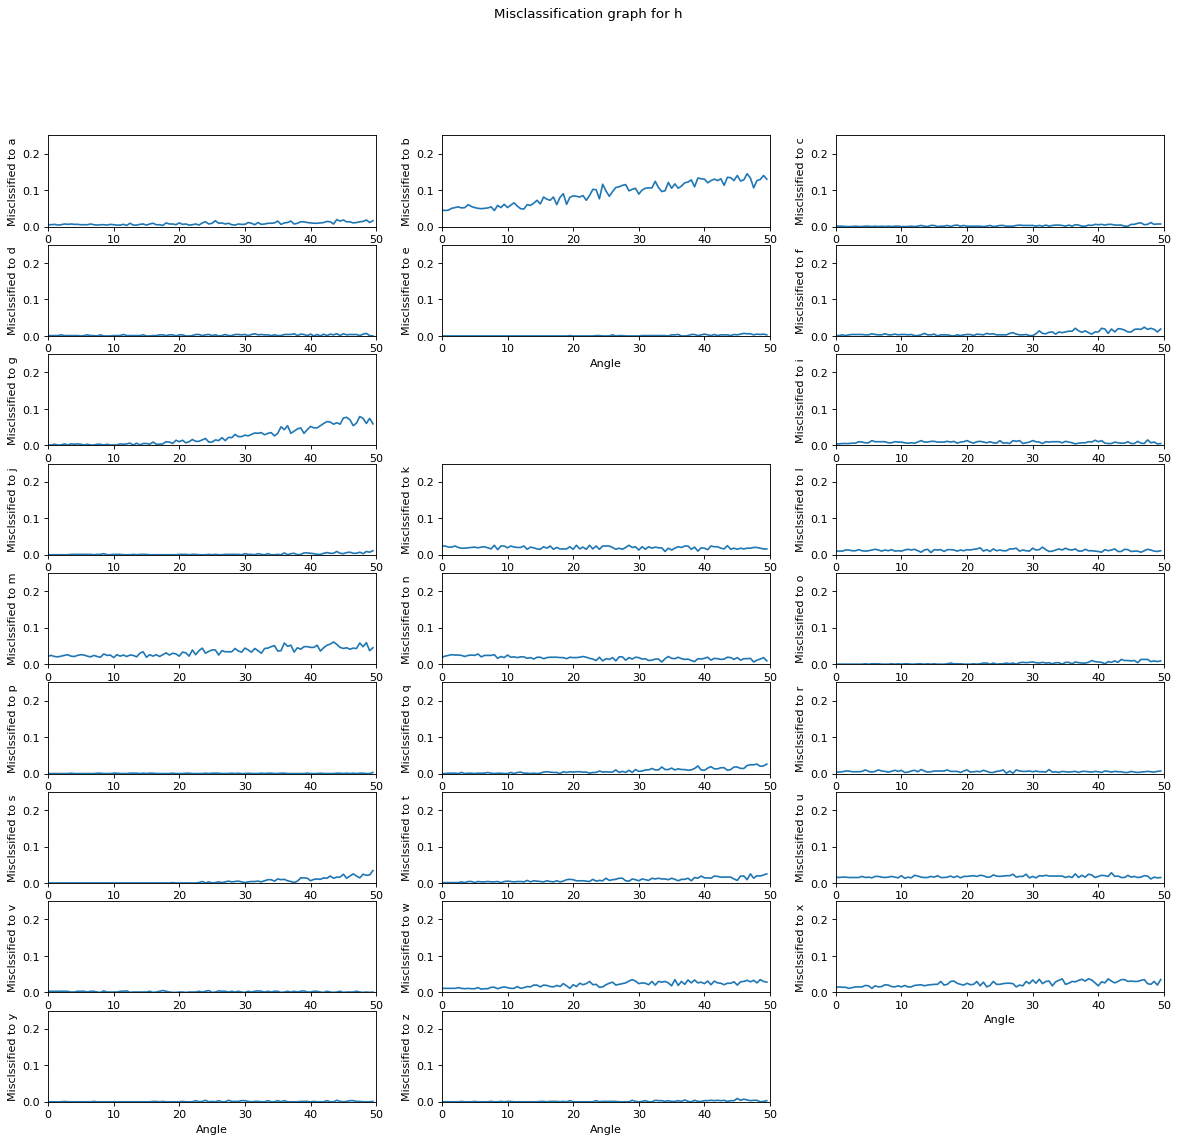

---------------------------------------------------------------------------------------------------------------------


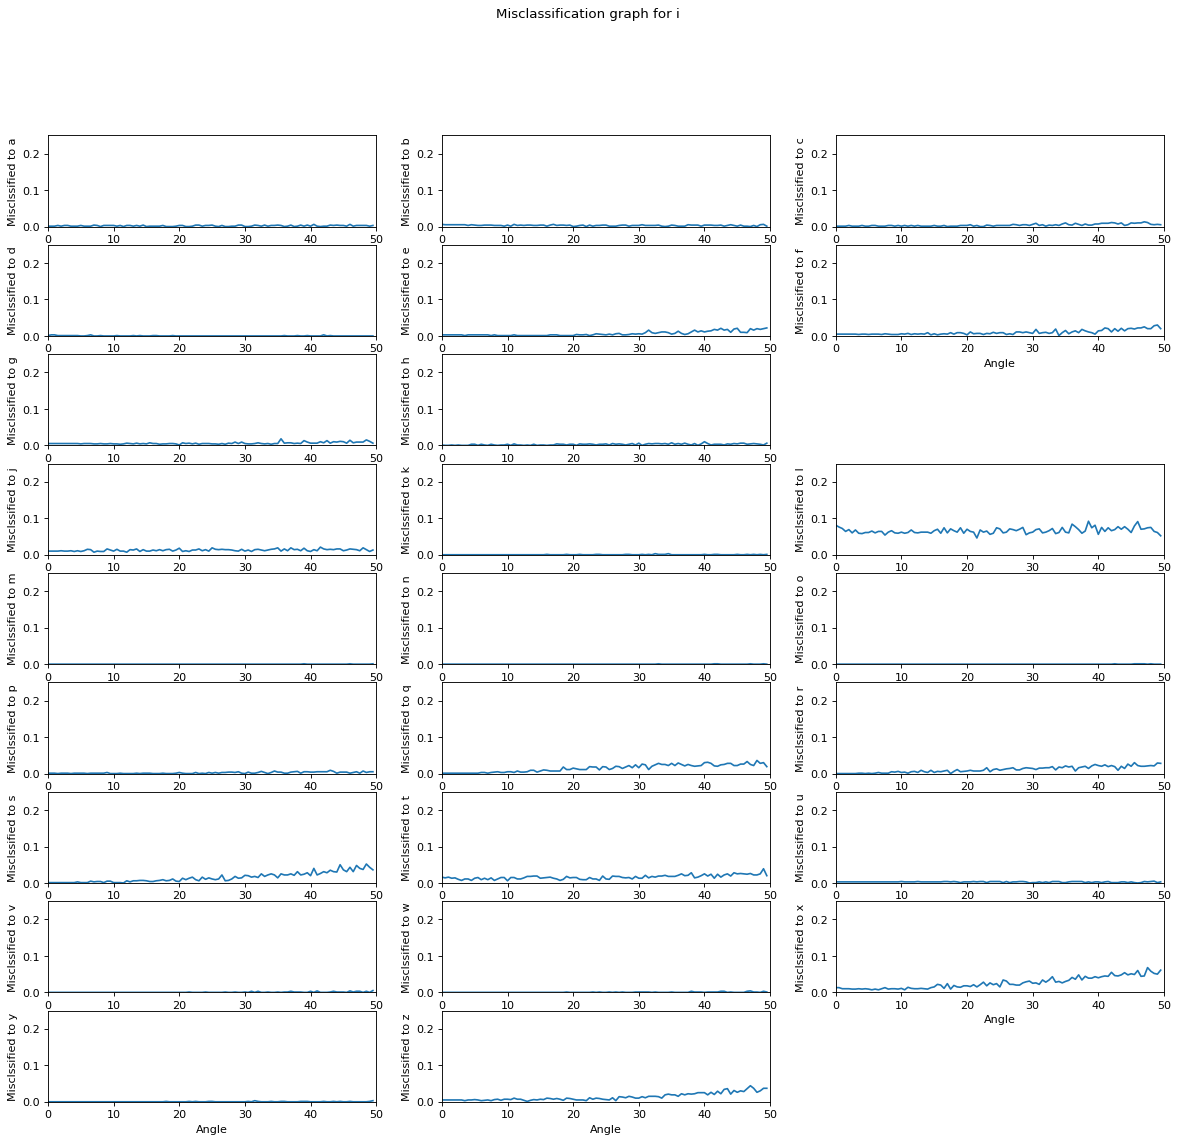

---------------------------------------------------------------------------------------------------------------------


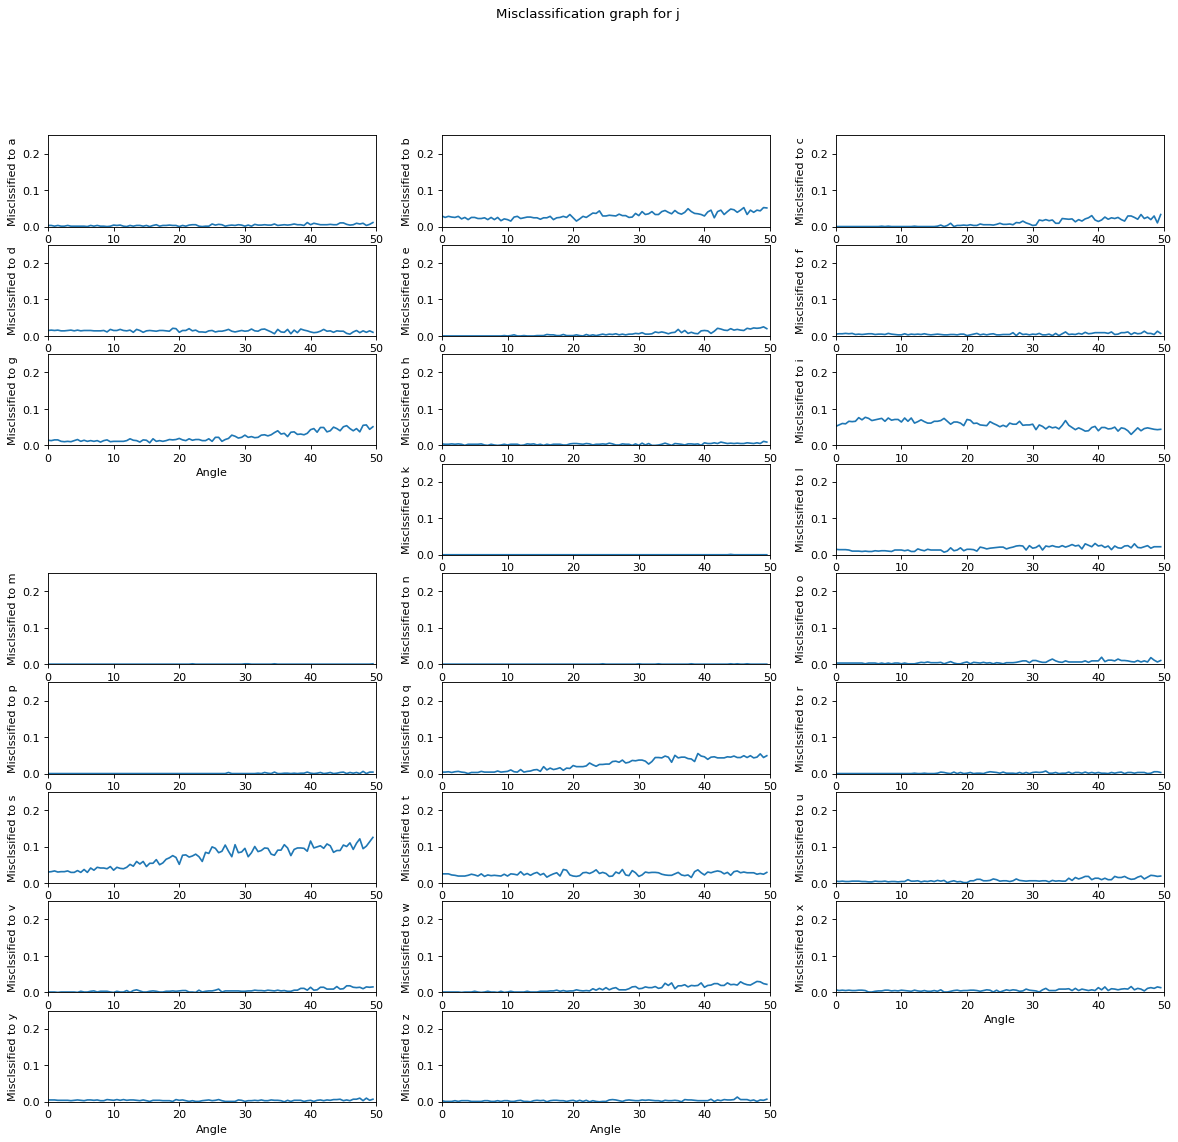

---------------------------------------------------------------------------------------------------------------------


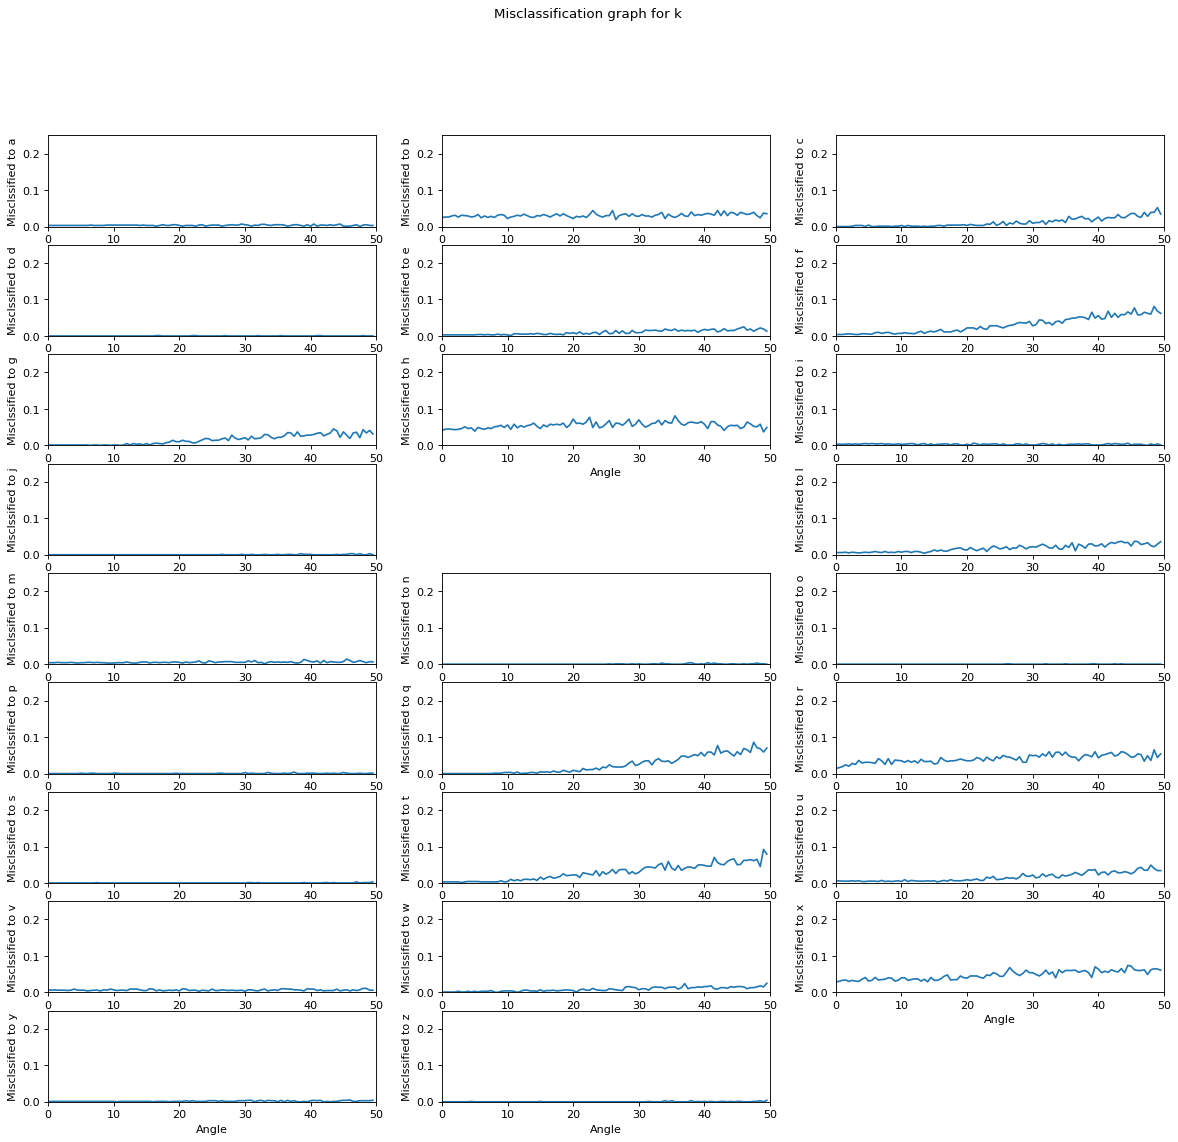

---------------------------------------------------------------------------------------------------------------------


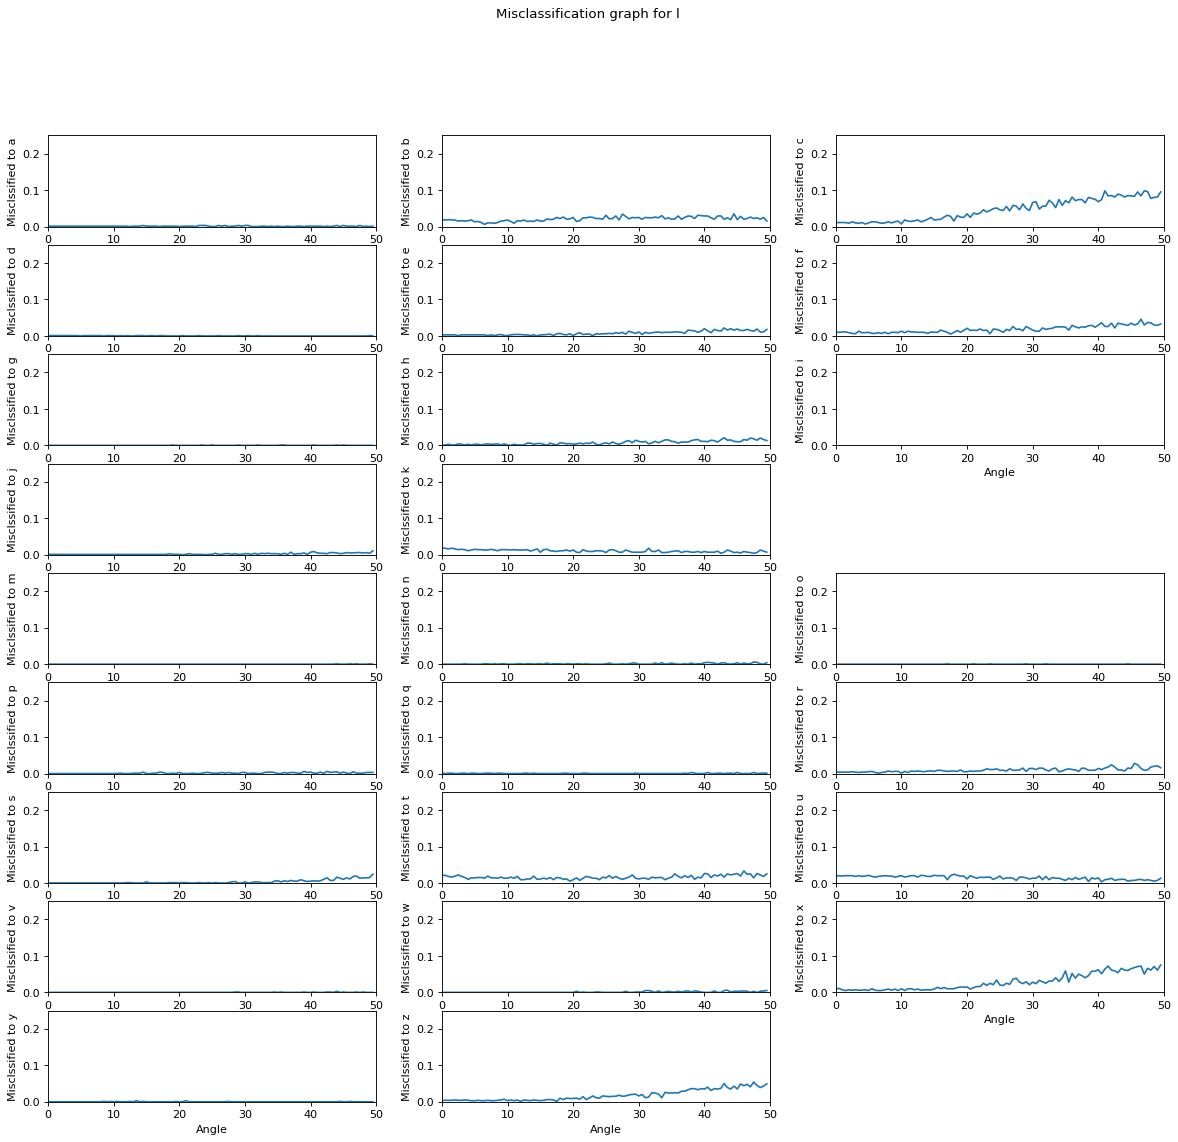

---------------------------------------------------------------------------------------------------------------------


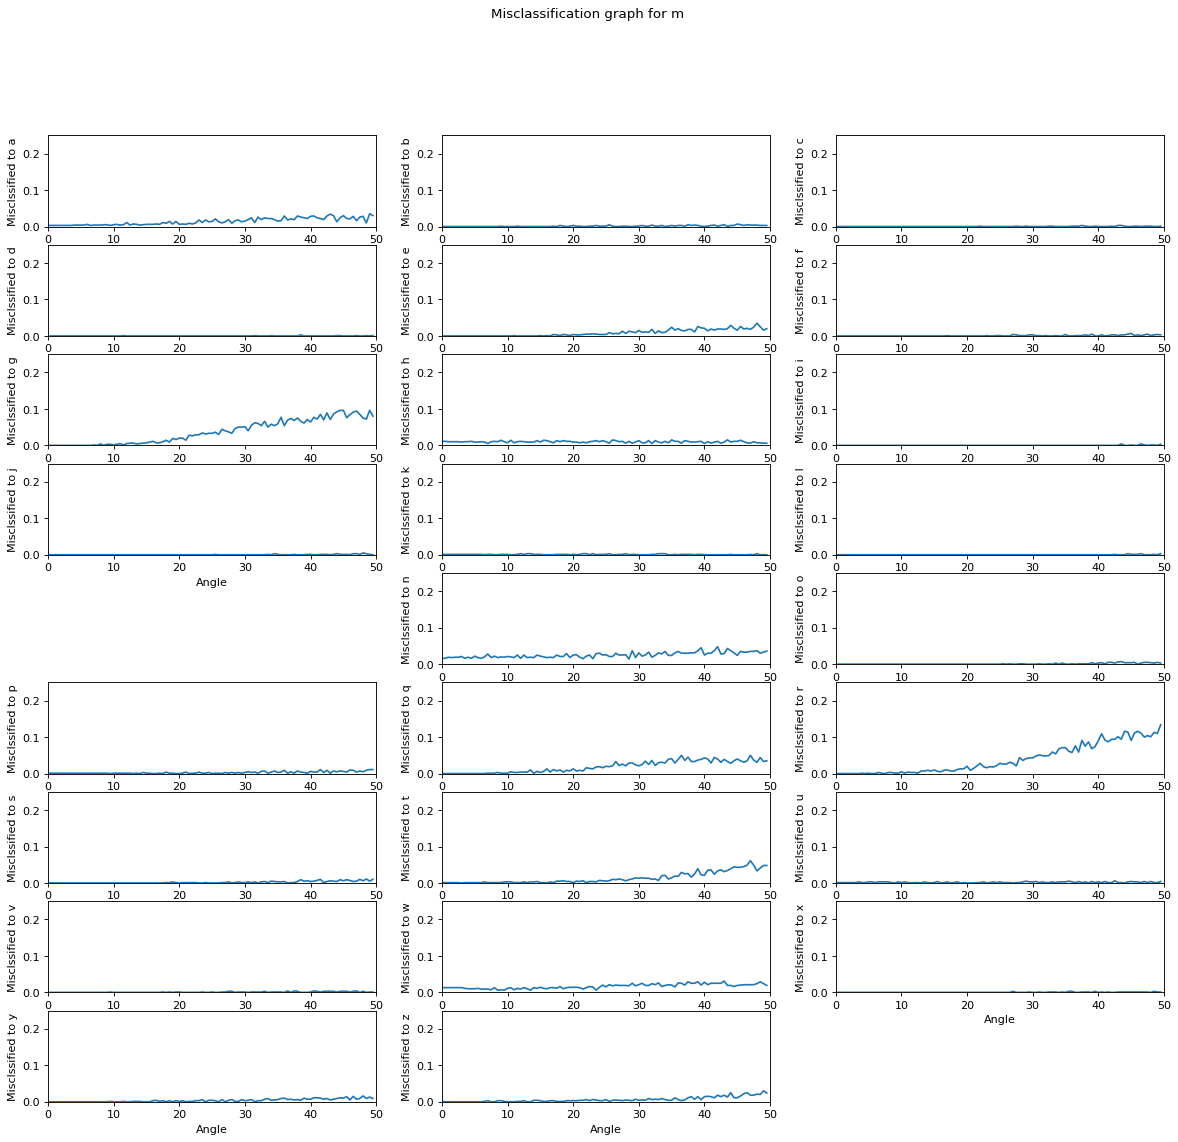

---------------------------------------------------------------------------------------------------------------------


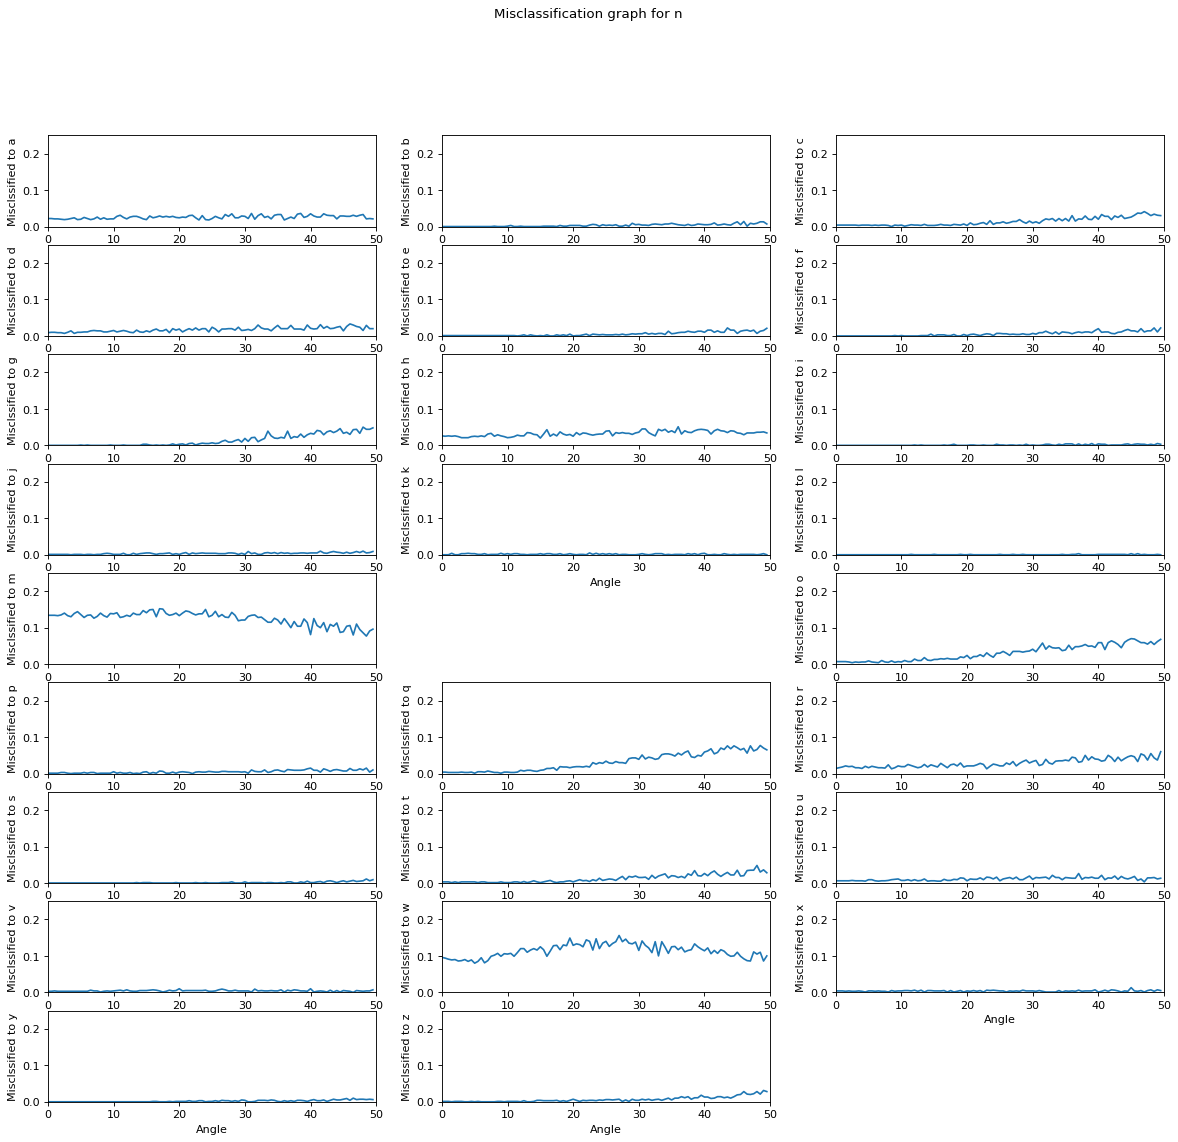

---------------------------------------------------------------------------------------------------------------------


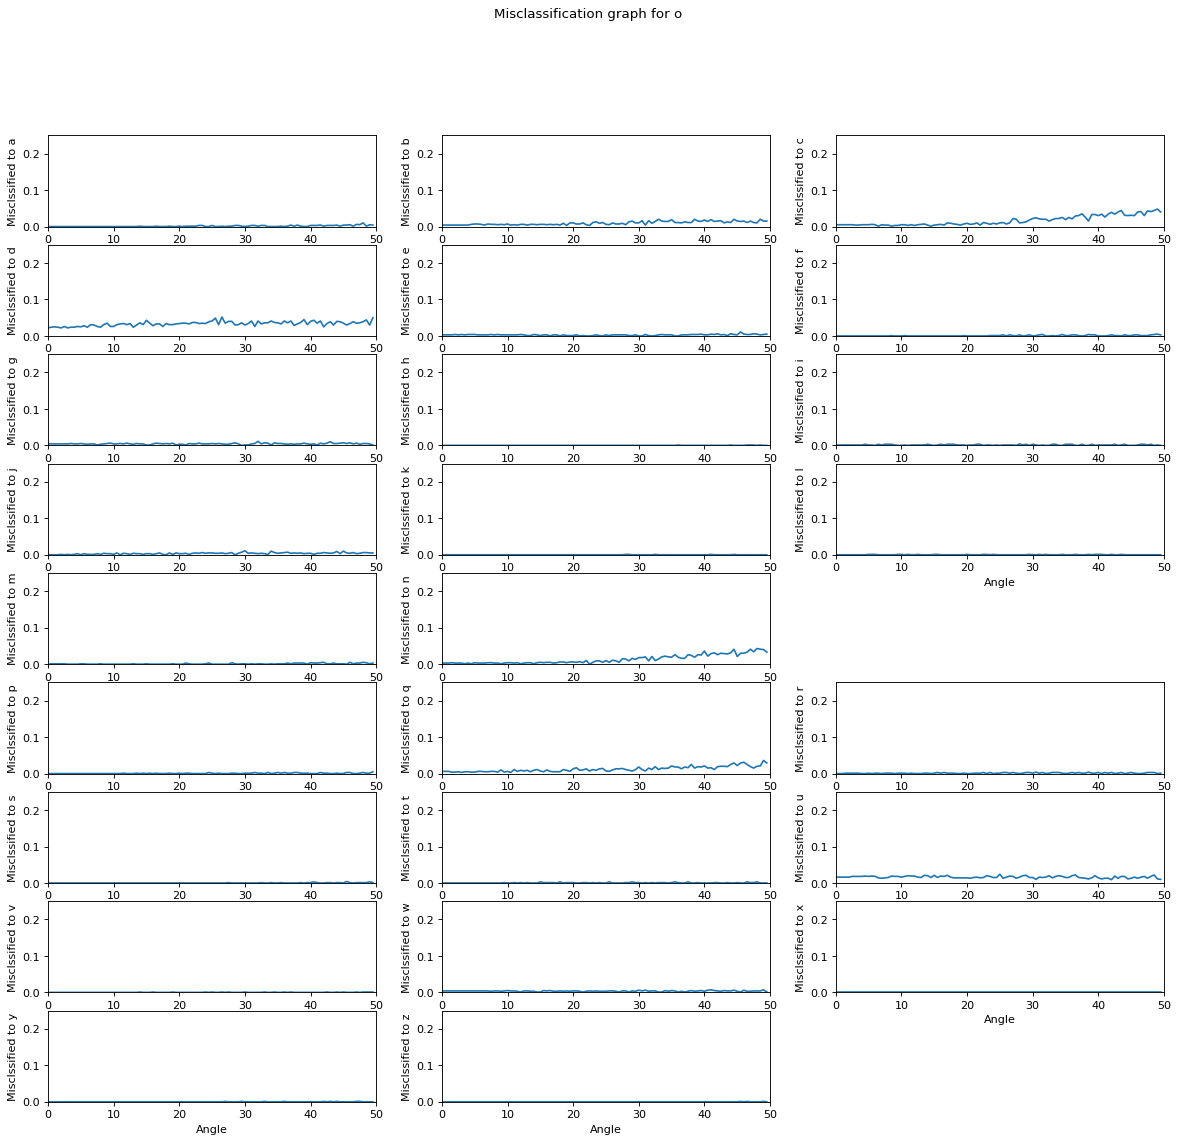

---------------------------------------------------------------------------------------------------------------------


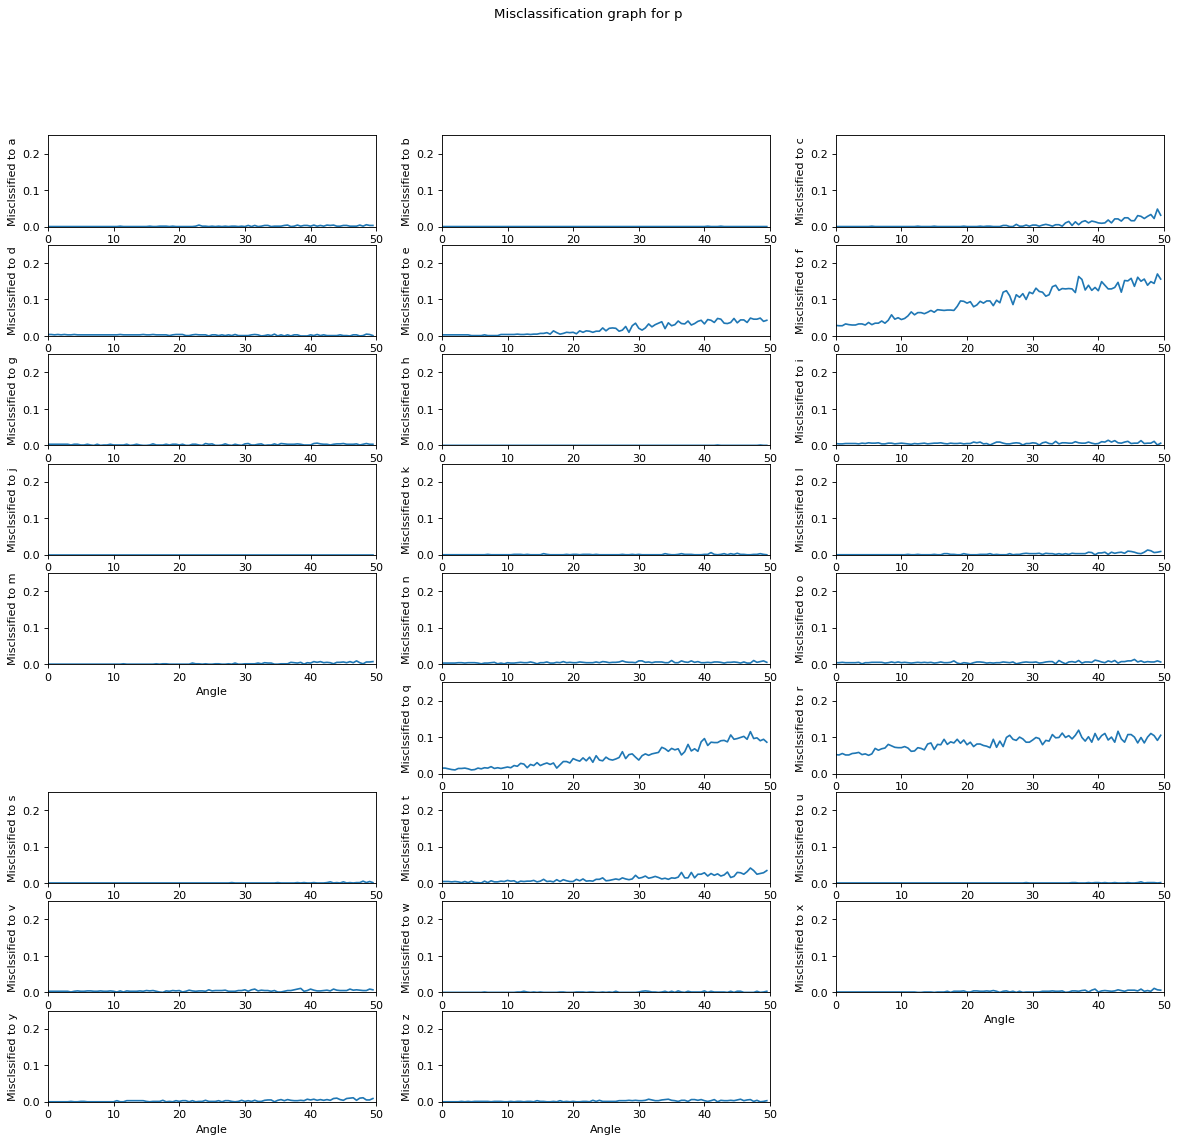

---------------------------------------------------------------------------------------------------------------------


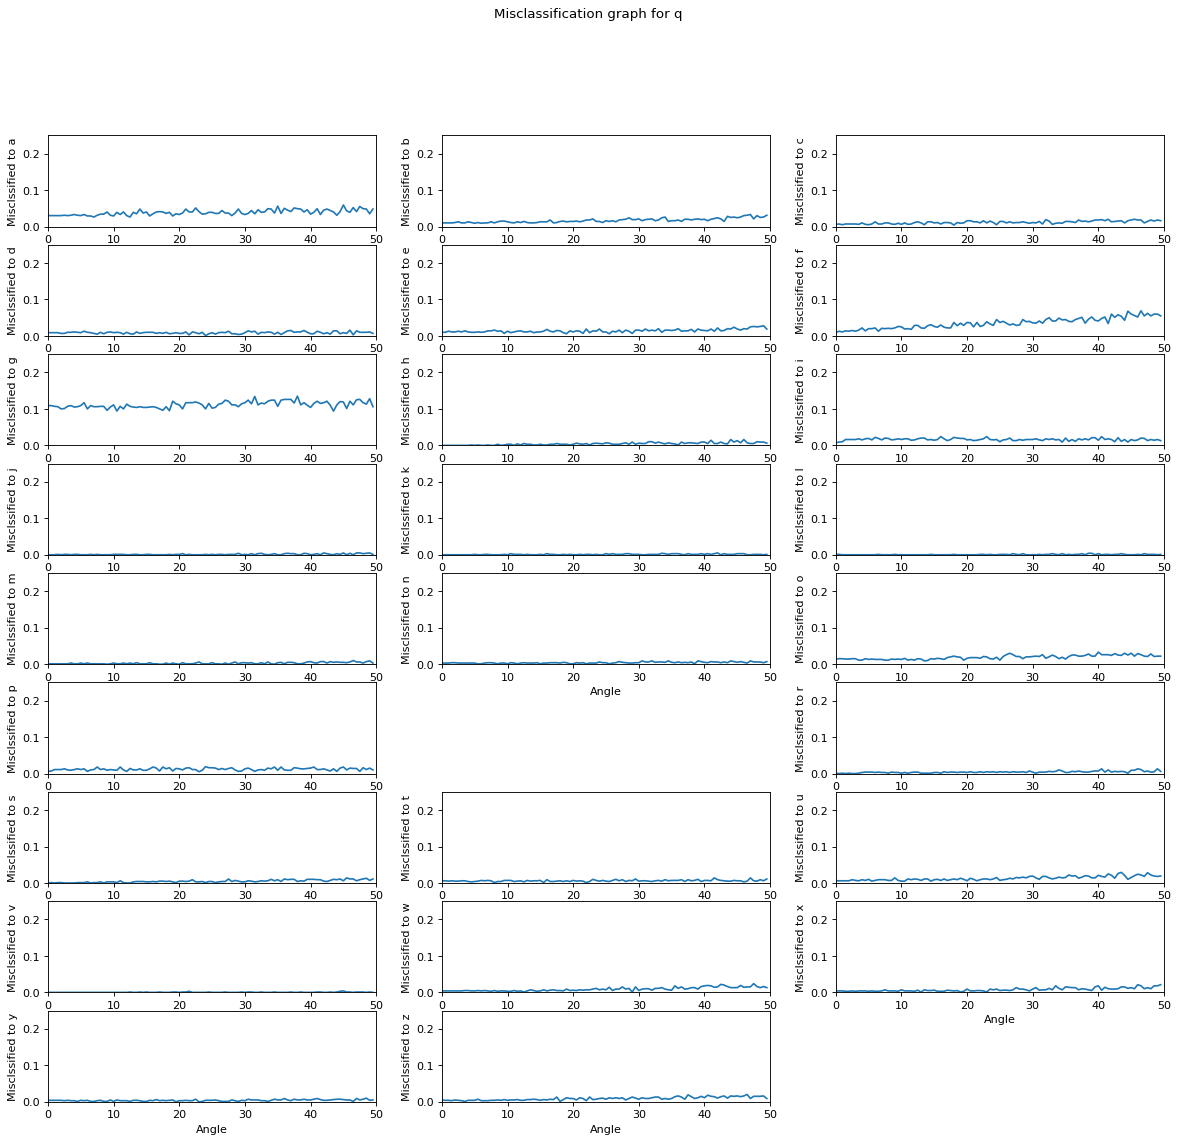

---------------------------------------------------------------------------------------------------------------------


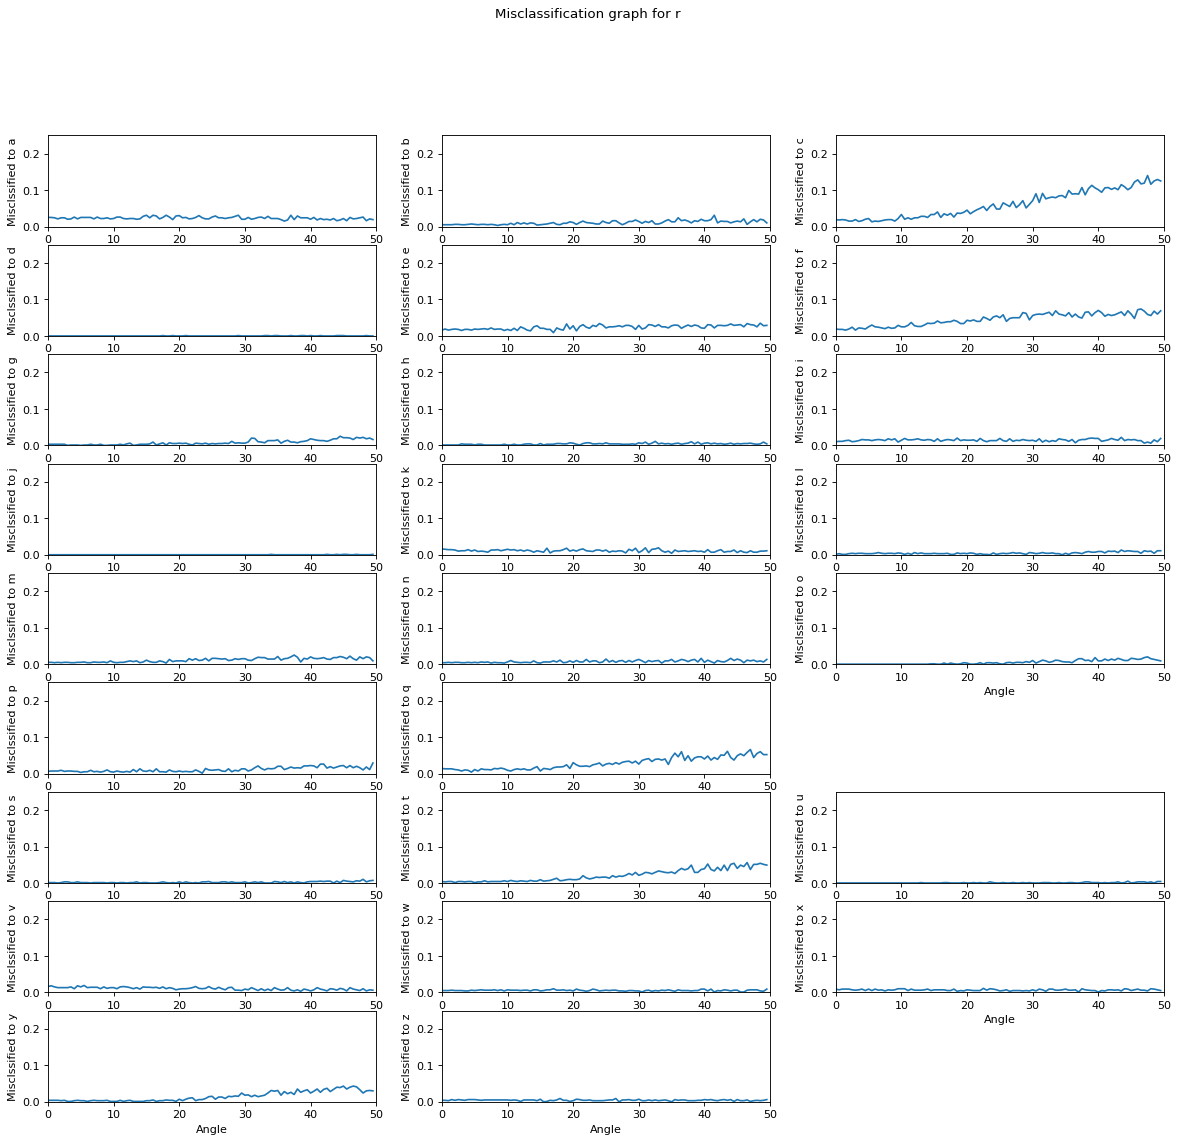

---------------------------------------------------------------------------------------------------------------------


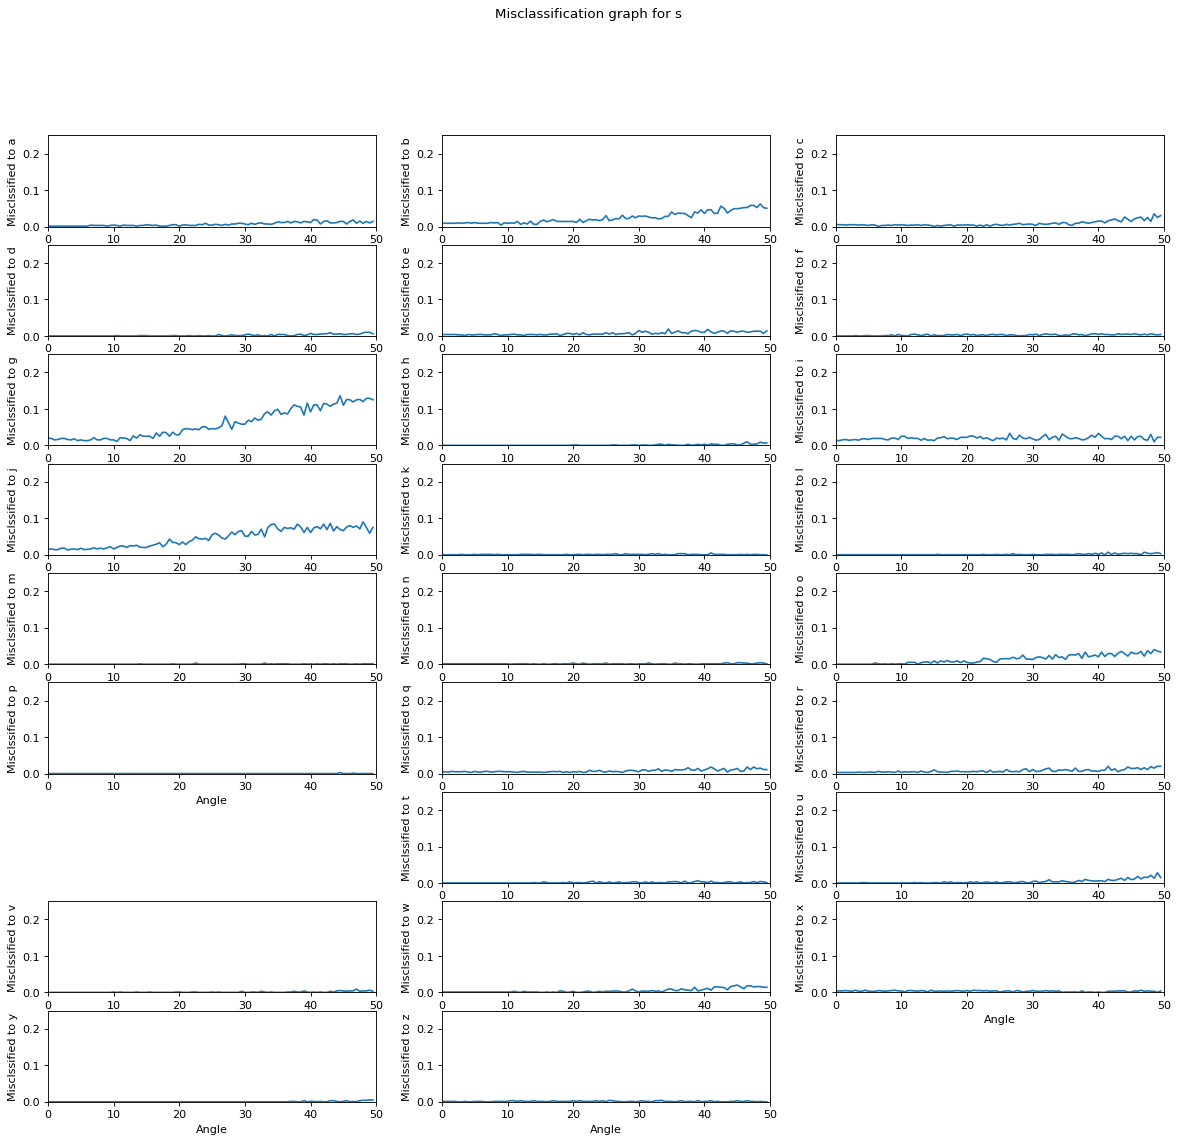

---------------------------------------------------------------------------------------------------------------------


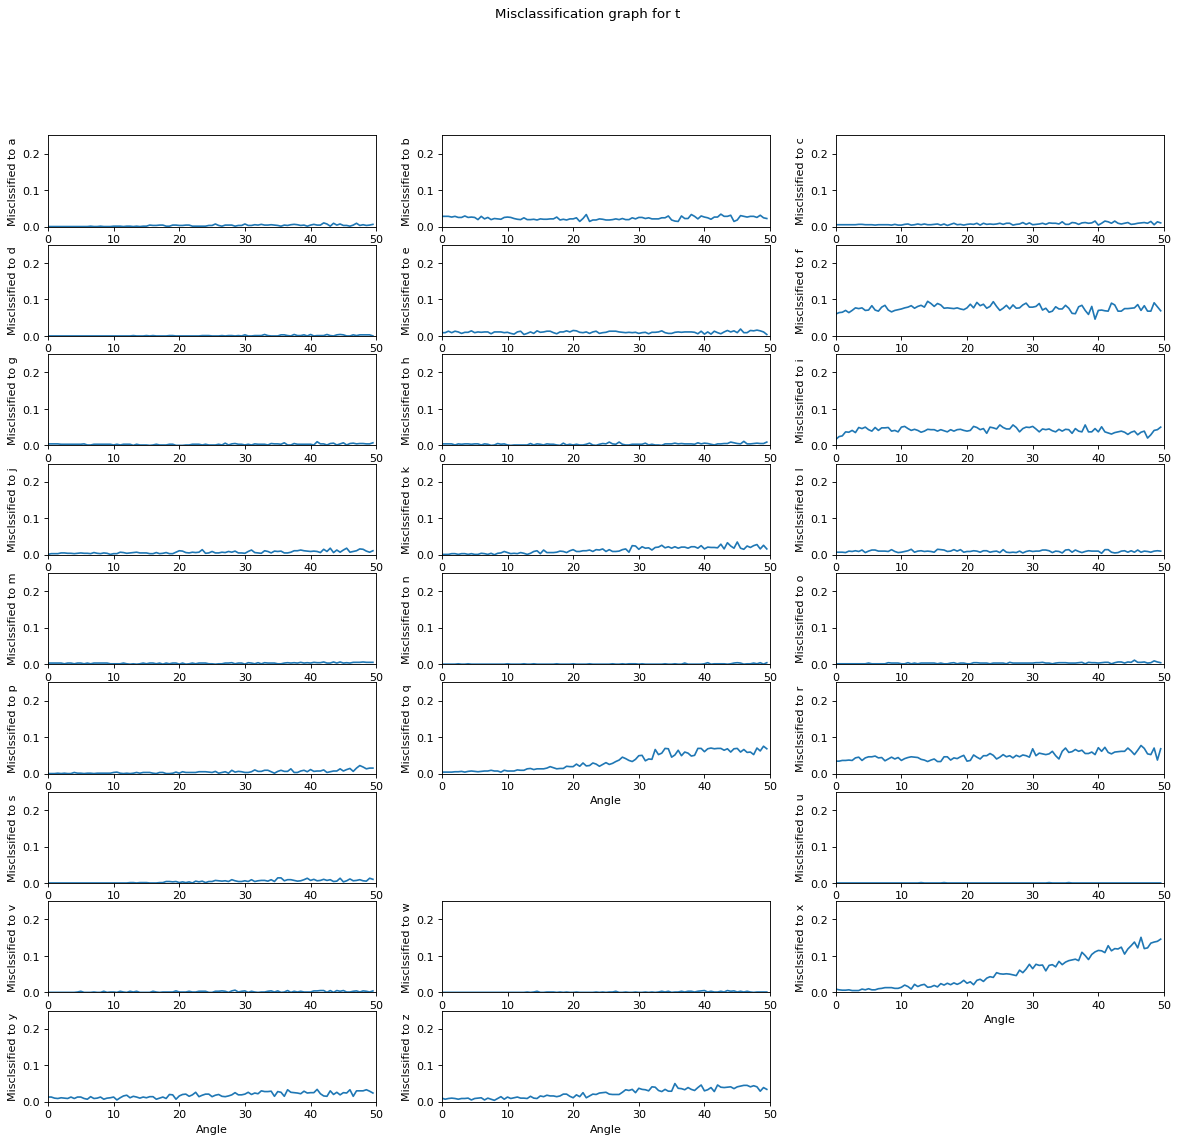

---------------------------------------------------------------------------------------------------------------------


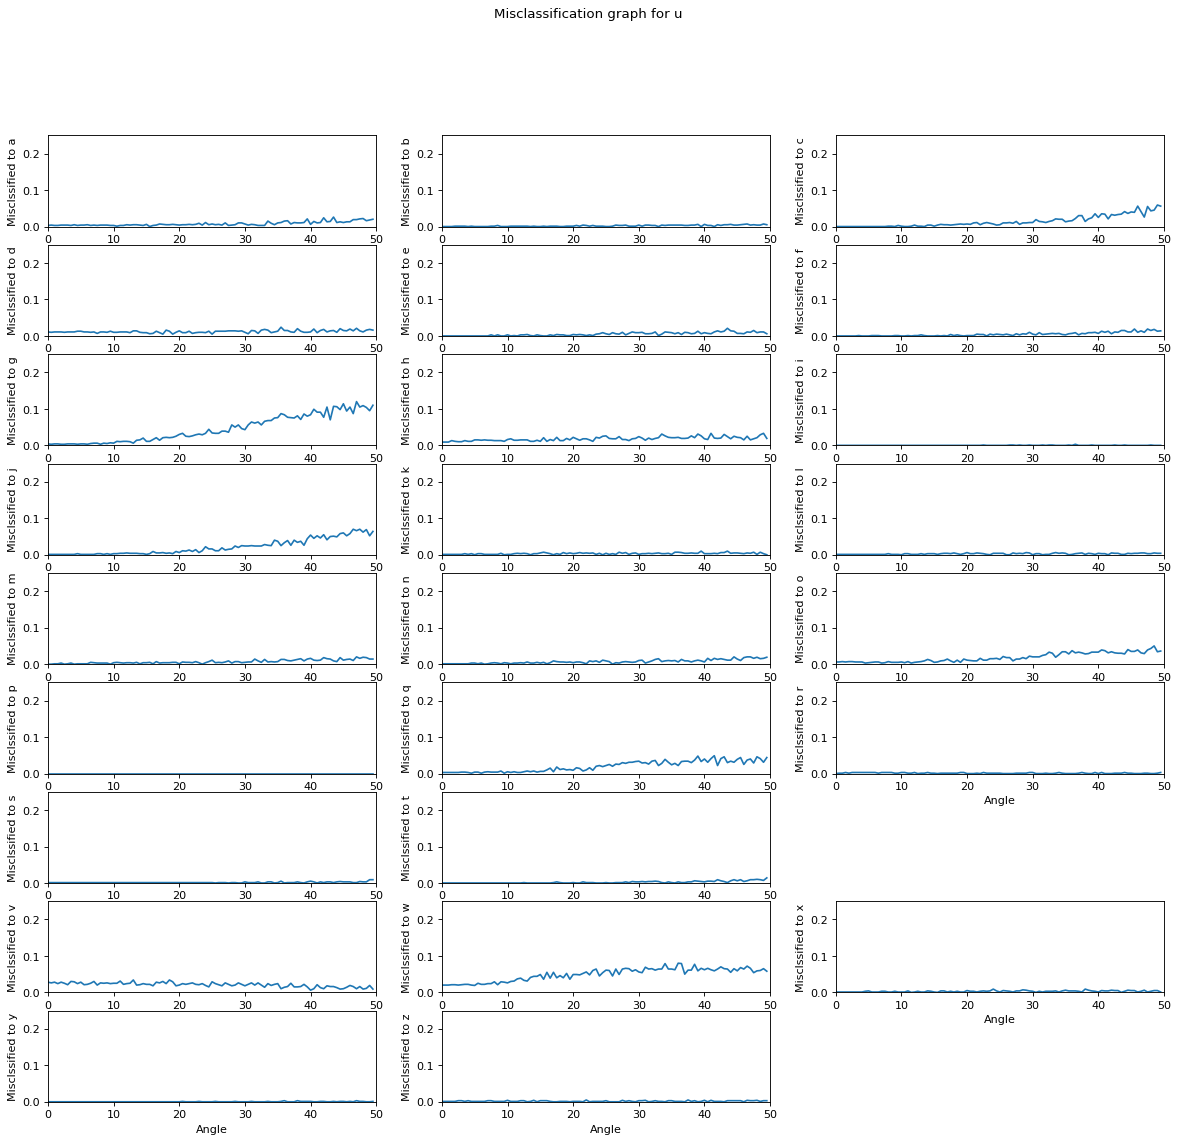

---------------------------------------------------------------------------------------------------------------------


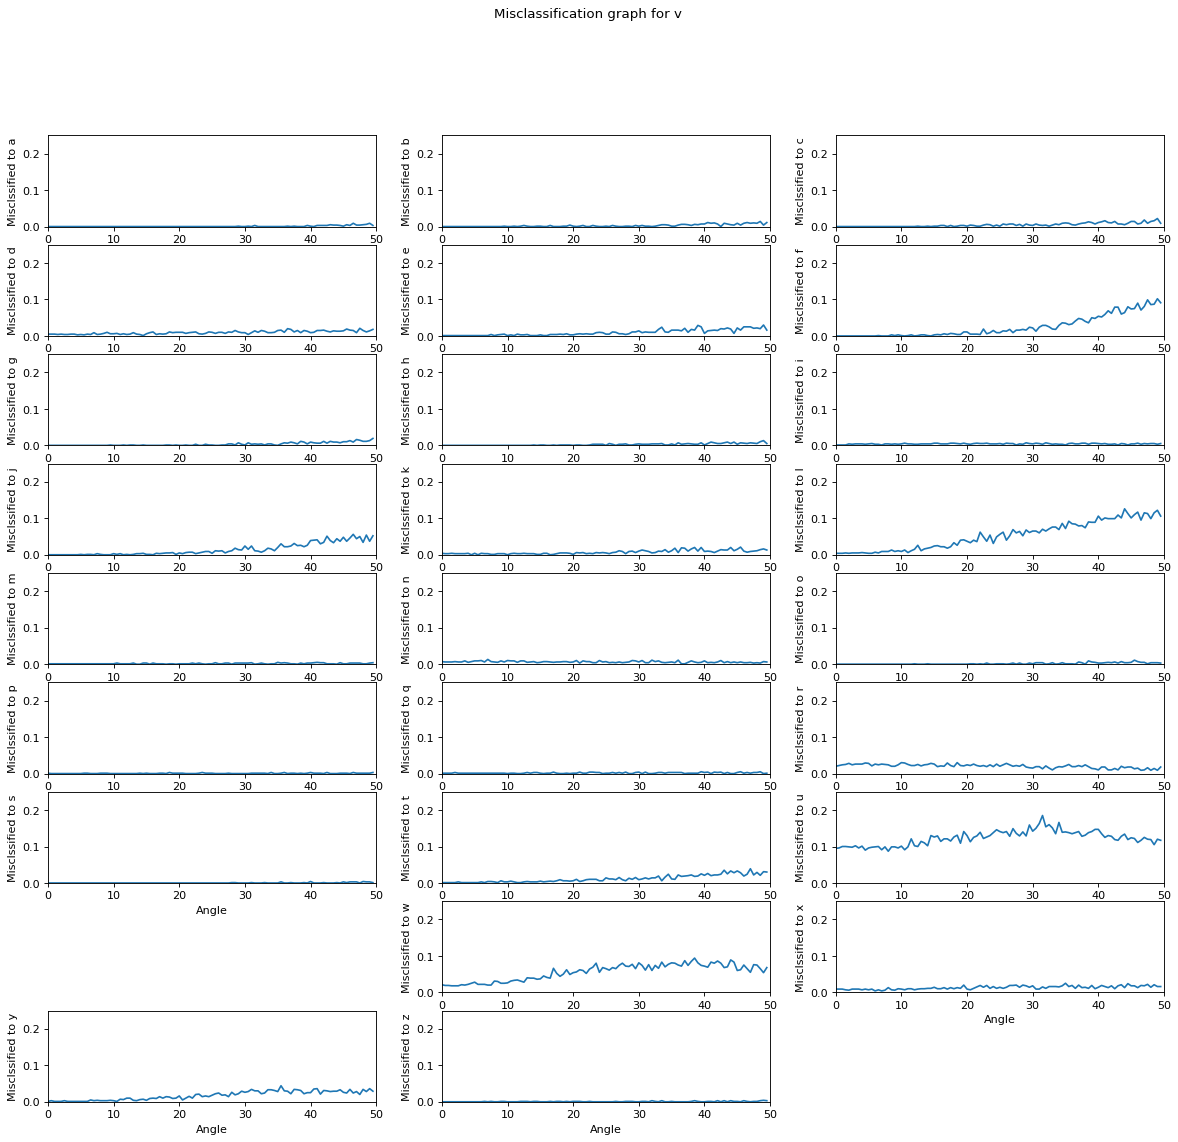

---------------------------------------------------------------------------------------------------------------------


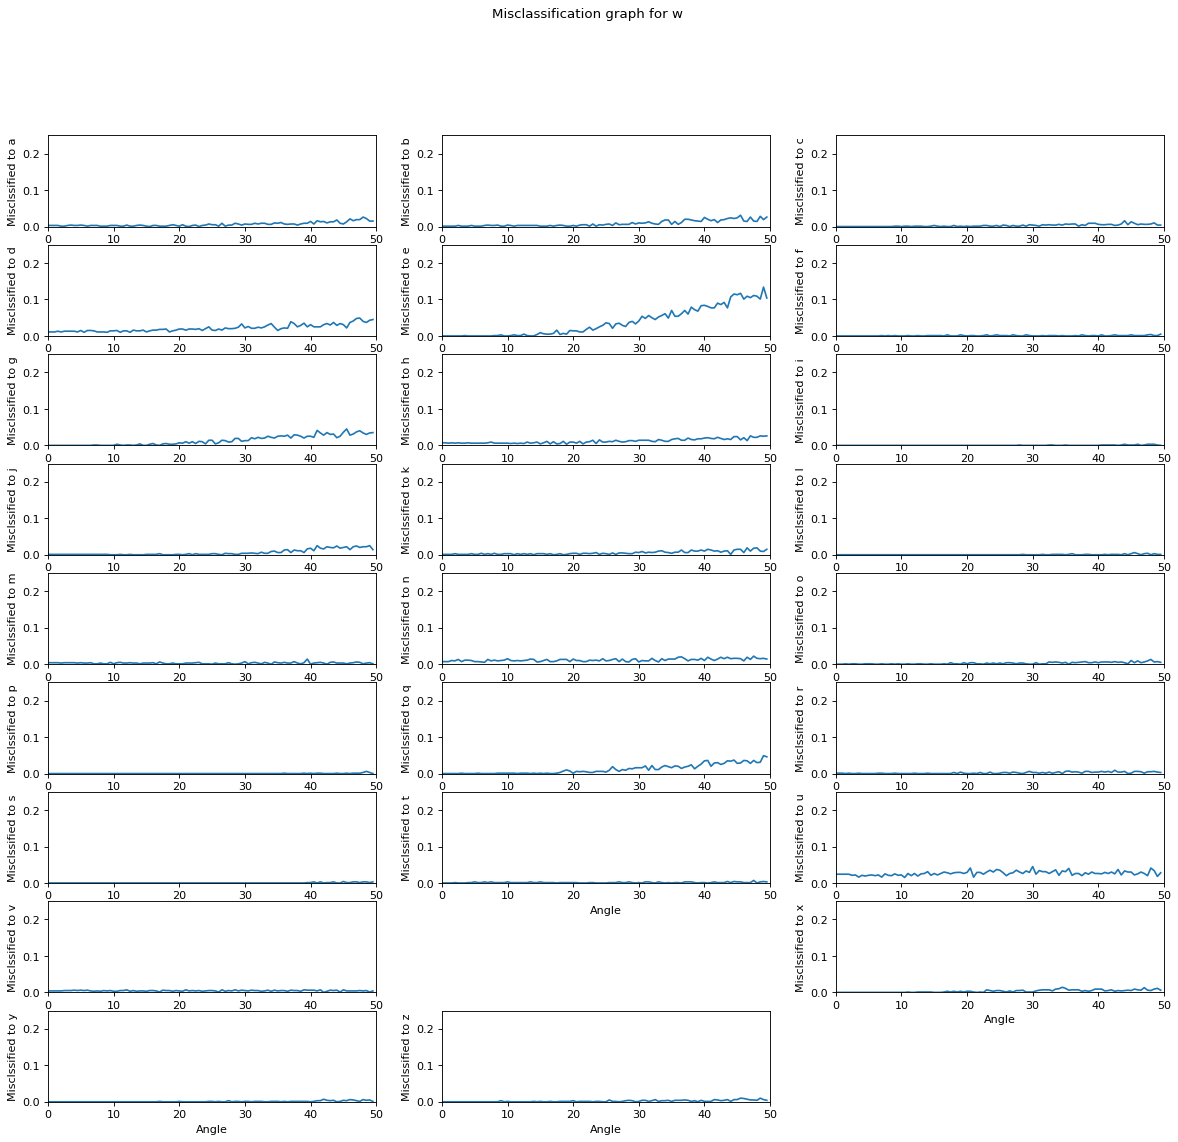

---------------------------------------------------------------------------------------------------------------------


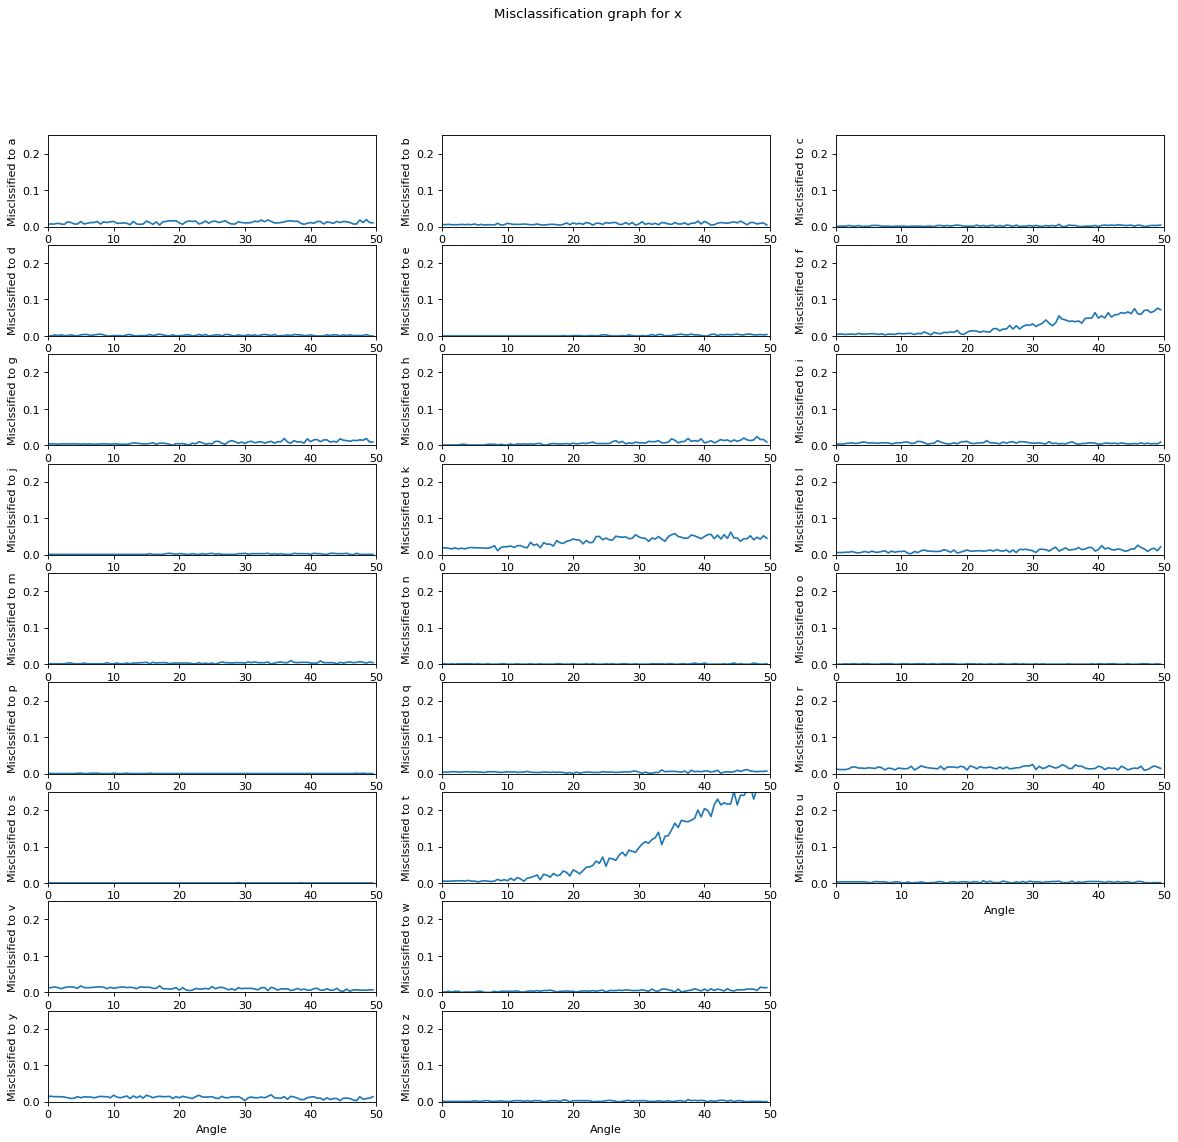

---------------------------------------------------------------------------------------------------------------------


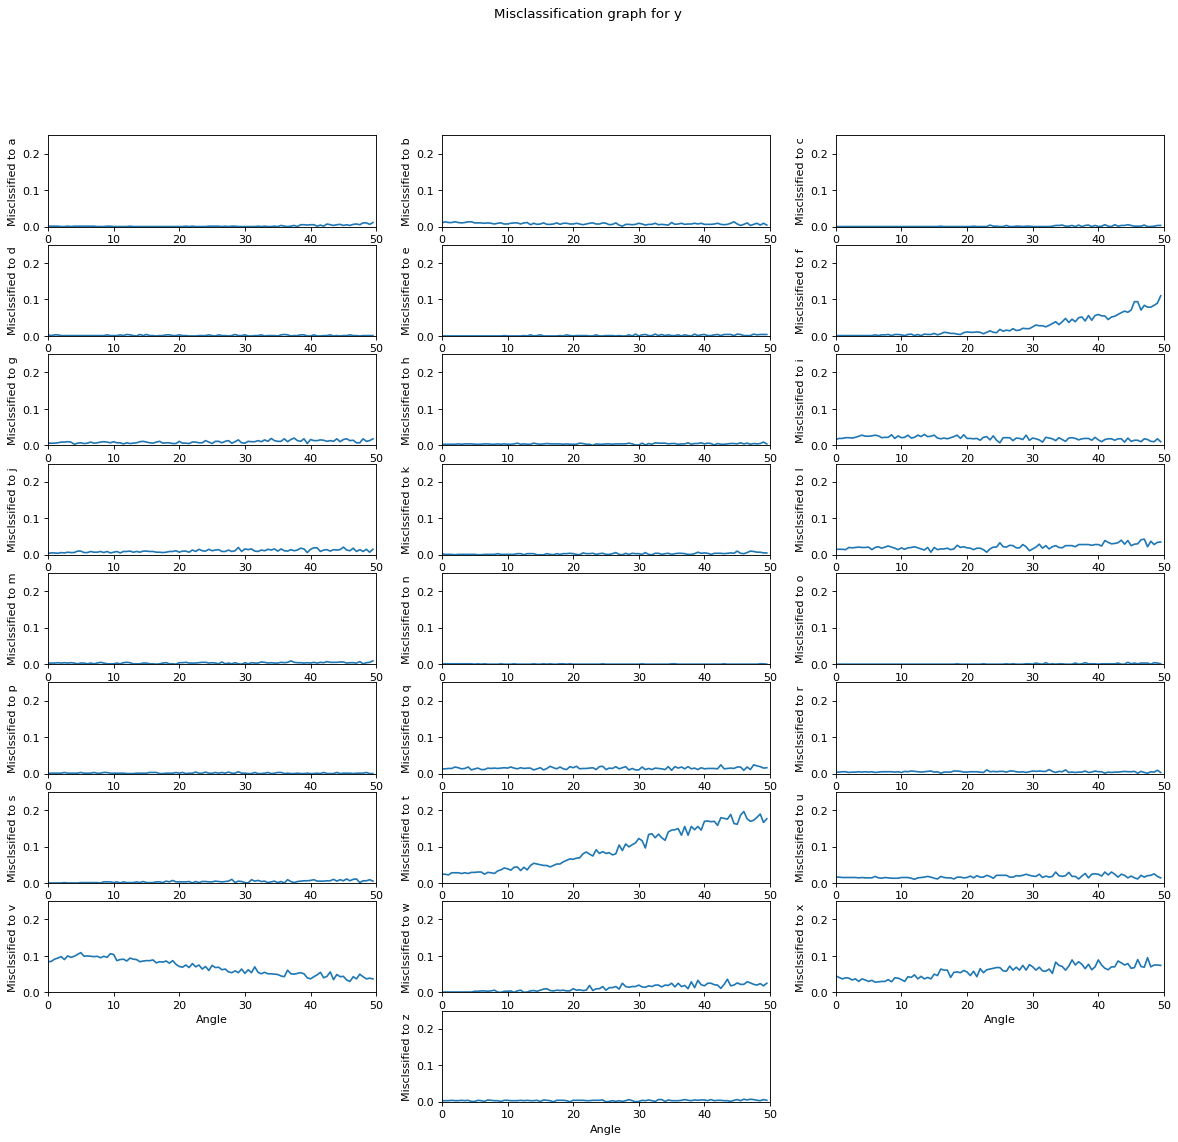

---------------------------------------------------------------------------------------------------------------------


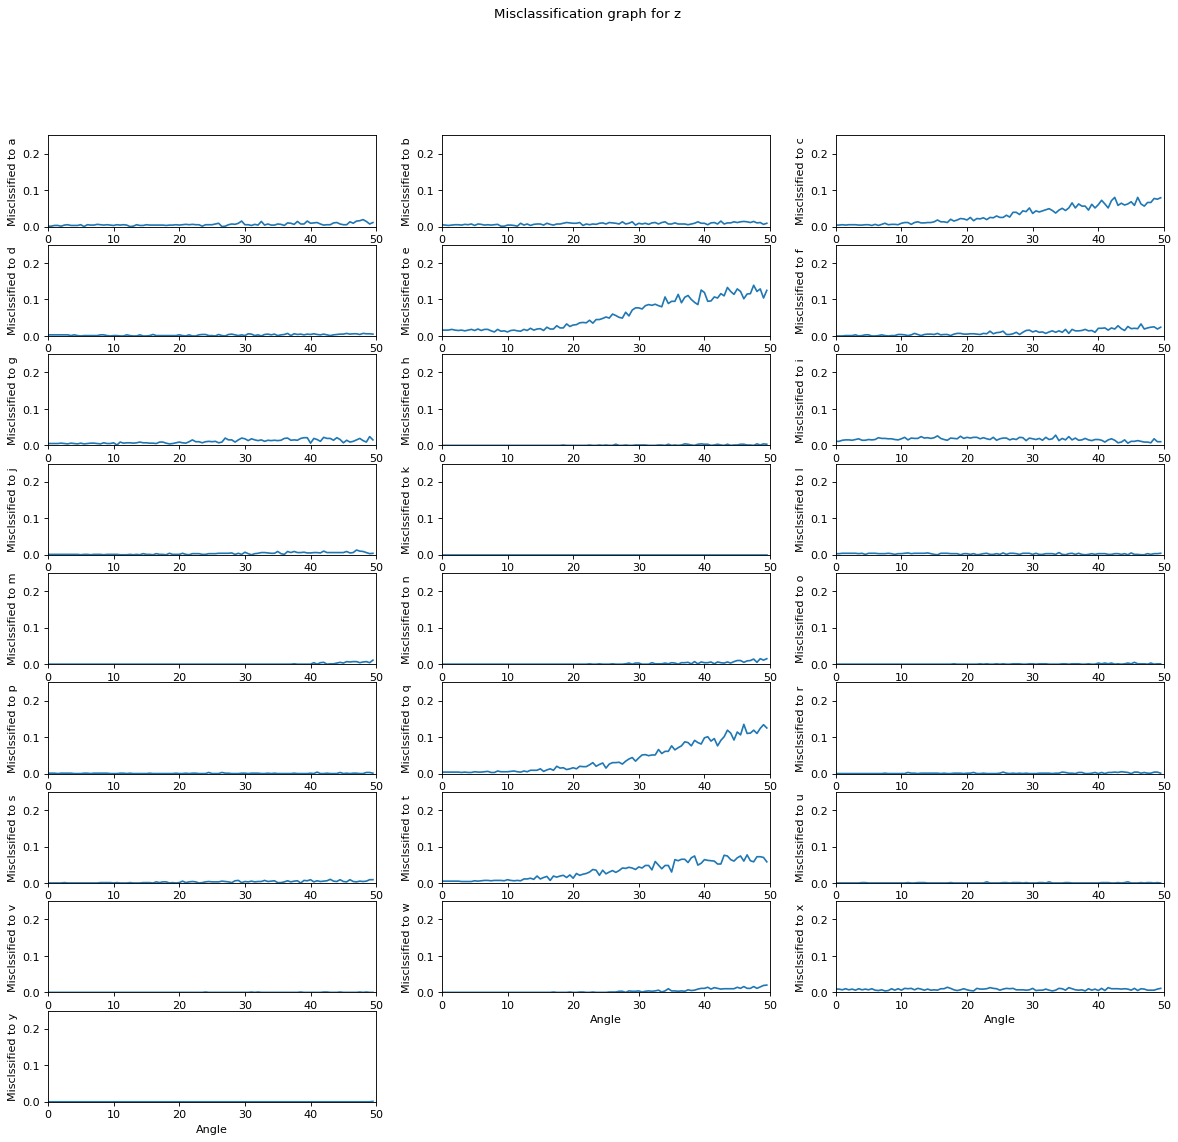

---------------------------------------------------------------------------------------------------------------------


In [29]:
zero = []

for j in range(num_classes):
    figure(num=None, figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
    for k in range(0,num_classes):
        zero = []
        if j != k: 
            for i in range(len(aMatrix)):
                zero.append(aMatrix[i][j][k])
        else:
            continue       
        plt.subplot(9,3,k+1)
        plt.axis([0, 50, 0, 0.25])
        plt.plot(np.arange(0,50,0.5),zero)
        plt.xlabel("Angle")
        plt.ylabel("Misclssified to %s" %chr(97+k))
    plt.suptitle("Misclassification graph for %s" %(chr(97+j)))
    plt.show()
    print("---------------------------------------------------------------------------------------------------------------------")